In [1]:
import loconsensus.loconsensus as loconsensus
import locomotif.visualize as visualize
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathlib import Path

s_dir = Path('../pickles/subjects.pkl')
with open(s_dir, 'rb') as f:
    subjects = pickle.load(f)

(600, 3)
(600, 3)
(600, 3)
(600, 3)
(600, 3)
(600, 3)
(600, 3)
(600, 3)
(600, 3)
(600, 3)
(600, 3)
(600, 3)
(600, 3)
(600, 3)
['0: w-n', '1: n-w', '2: w-n', '3: n-w', '4: w-n', '5: n-w', '6: w-n', '7: r-d', '8: d-r', '9: r-d', '10: d-r', '11: c-c', '12: c-c', '13: c-c']


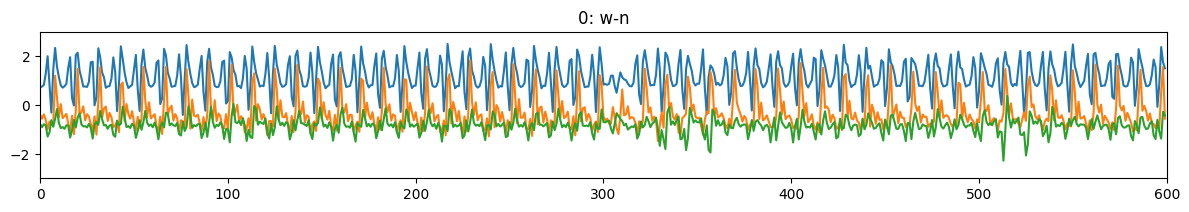

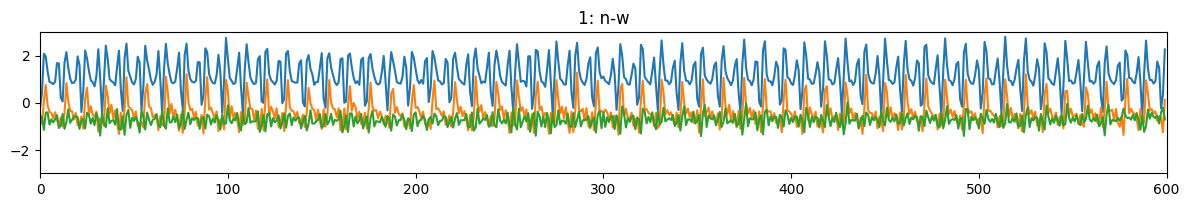

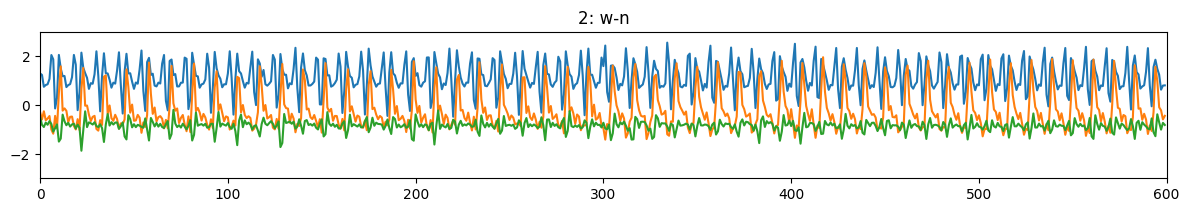

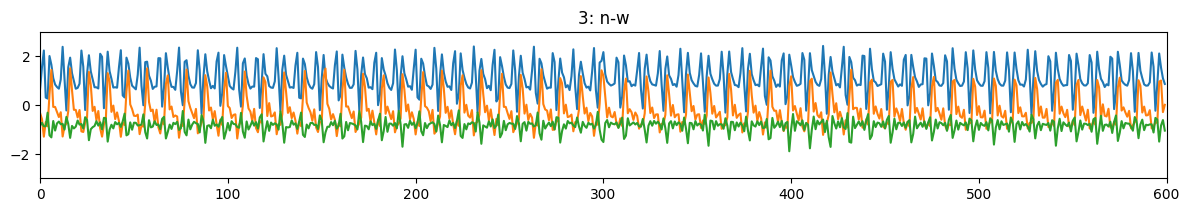

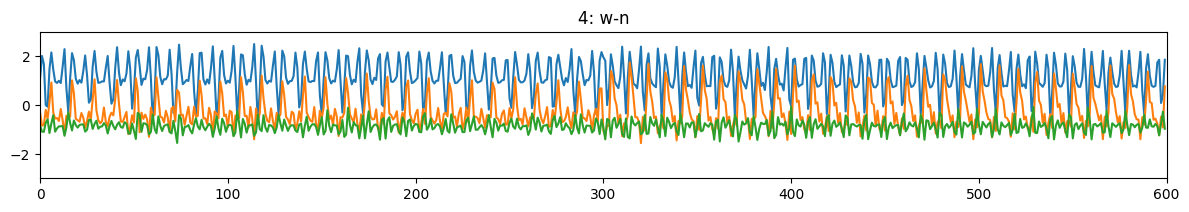

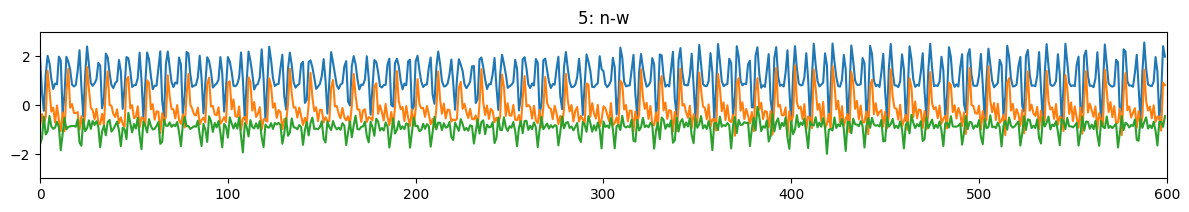

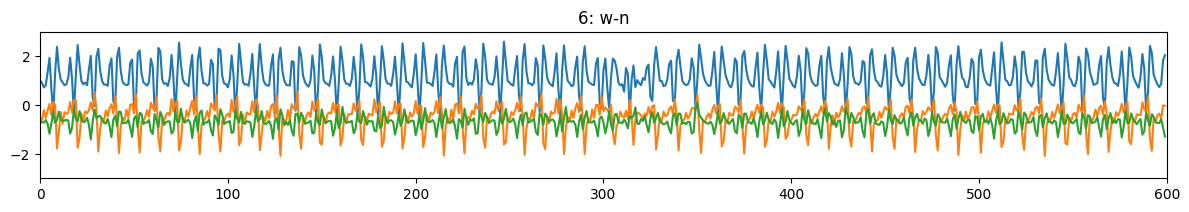

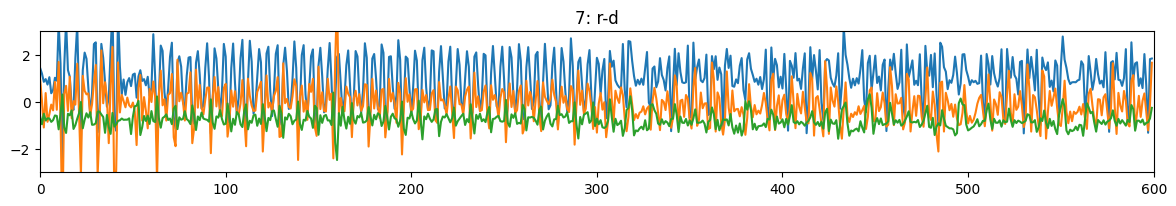

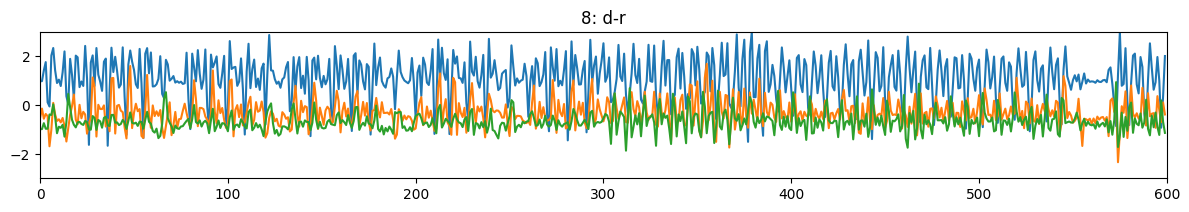

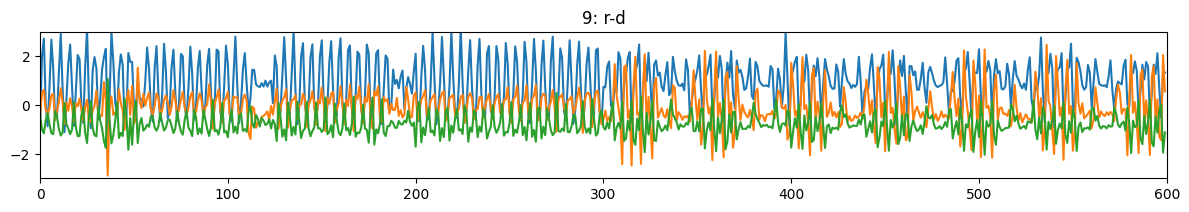

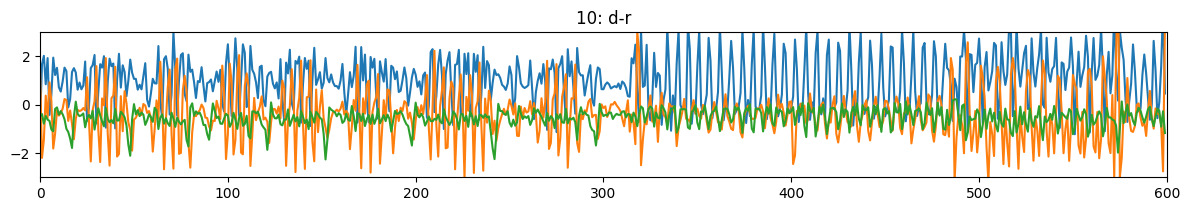

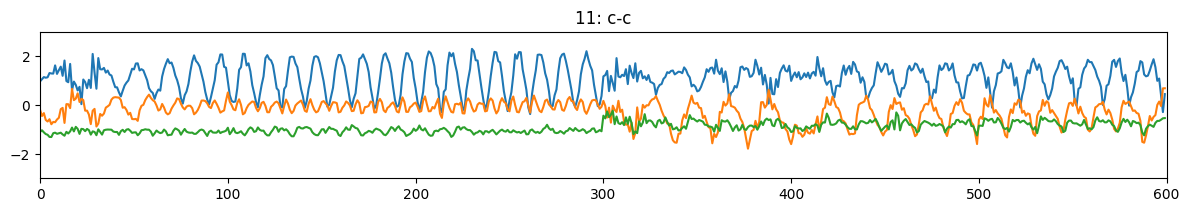

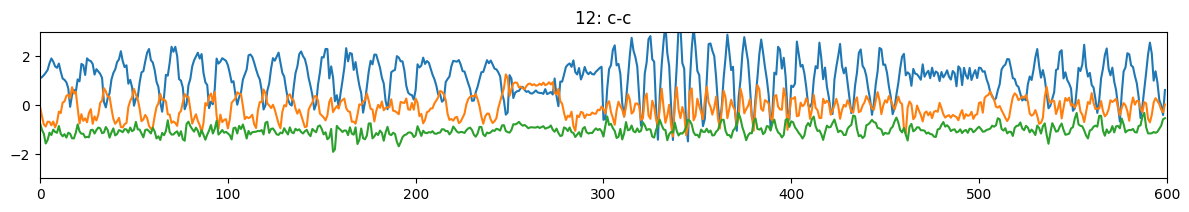

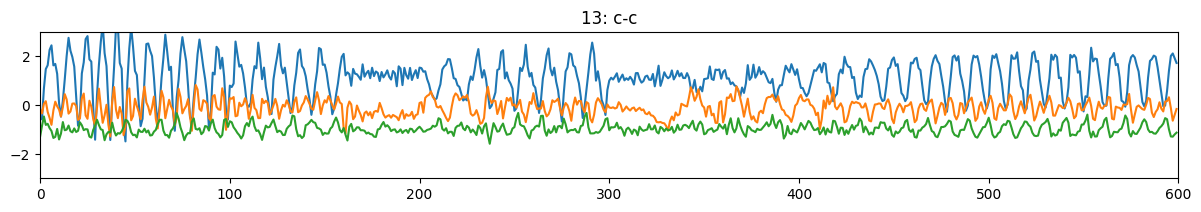

In [142]:
def create_permutated_ts_list(ts_names, subjects, sampling_frequency=10):
    labels = []
    ts_list = []
    it = iter(ts_names)
    i=0
    for (s1, a1), (s2, a2) in zip(it, it):
        ts = np.concatenate((
            subjects.get(f'subject10{s1}').get(a1)[100:40*sampling_frequency, 6:9],
            subjects.get(f'subject10{s2}').get(a2)[100:40*sampling_frequency, 6:9],
        ))
        ts_list.append(ts)
        labels.append((f'{i}: {a1[0]}-{a2[0]}'))
        i+=1

    return ts_list, labels

gt = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2,]

ts_names = [(1, 'walking'), (1, 'nordic_walking'),
            (2, 'nordic_walking'), (2, 'walking'),
            (4, 'walking'), (4, 'nordic_walking'),
            (5, 'nordic_walking'), (5, 'walking'),
            (6, 'walking'), (6, 'nordic_walking'),
            (7, 'nordic_walking'), (7, 'walking'),
            (8, 'walking'), (8, 'nordic_walking'),

            (1, 'rope_jumping'), (1, 'desc_stairs'),
            (2, 'desc_stairs'), (2, 'rope_jumping'),
            (5, 'rope_jumping'), (5, 'desc_stairs'),
            (8, 'desc_stairs'), (8, 'rope_jumping'),

            (1, 'cycling'), (2, 'cycling'),
            (4, 'cycling'), (6, 'cycling'),
            (6, 'cycling'), (7, 'cycling'),]
ts_list, labels = create_permutated_ts_list(ts_names, subjects)
for ts in ts_list:
    print(ts.shape)
print(labels)

for i, ts in enumerate(ts_list):
    fig, ax = visualize.plot_motif_sets(ts, [], legend=False)
    ax[0].set_ylim([-3, 3])
    ax[0].set_title(labels[i])
    plt.show()

In [139]:
n = len(ts_list)
global_offsets = np.cumsum([0] + [len(ts) for ts in ts_list])
l_min = 15
l_max = 30
rho = 0.8

nb = None

ms = loconsensus.apply_loconsensus(ts_list, l_min, l_max, rho, nb, overlap=0.5)

In [140]:
cm = []
for _, mset, _, bf in ms:
    cm.append((mset, bf))

cms = []
for mset, bf in cm:
    m = {i: [] for i in range(n)}
    for (s, e) in mset:
        i = np.sum(global_offsets <= s) - 1
        m[i].append(((s - global_offsets[i], e - global_offsets[i]), bf))
    cms.append(m)

S = np.zeros((n, n))

for cs in cms:
    for i in range(n):
        for j in range(n):
            cs1 = cs[i]
            cs2 = cs[j]
            mbf = 0
            for c in cs1:
                smbf = c[1]
                if smbf > mbf:
                    mbf = smbf
            for c in cs2:
                smbf = c[1]
                if smbf > mbf:
                    mbf = smbf
            if mbf == 0:
                continue
            # print(f'{mbf} // {len(cs1)} {len(cs2)}')
            S[i, j] += mbf * min(len(cs1), len(cs2))

smin = S.min()
smax = S.max()
S = (S - smin) / (smax - smin)

D = 1 - S
D[np.diag_indices(len(D))] = 0

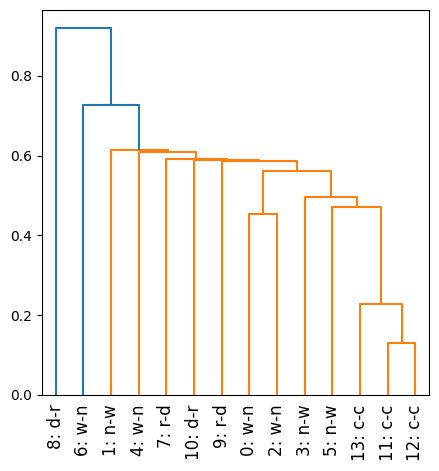

                    Method       ARI       NMI
0      Spectral Clustering  0.322917  0.498368
1  Hierarchical Clustering -0.028894  0.185798


In [141]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import pandas as pd

Cs = []
Zs = []
for n in [3]:
    spectral = SpectralClustering(n_clusters=n, affinity='precomputed')
    clusters = spectral.fit_predict(S)
    Cs.append(clusters)
    Z = linkage(squareform(D), method='single')
    h = fcluster(Z, n, criterion='maxclust')
    Zs.append(h)

    fig, ax = plt.subplots(figsize=(5, 5))
    dendrogram(Z, labels=labels, ax=ax, leaf_rotation=90)
    plt.show()

df = pd.DataFrame({'Label': labels})
for i, n in enumerate([3]):
    df[f'Spectral {n}'] = Cs[i]
    df[f'Hierarchical {n}'] = Zs[i]

df.set_index('Label', inplace=True)
#print(df)

ari2 = adjusted_rand_score(gt, Cs[0])
ari3 = adjusted_rand_score(gt, Zs[0])
nmi2 = normalized_mutual_info_score(gt, Cs[0])
nmi3 = normalized_mutual_info_score(gt, Zs[0])
df_metrics = pd.DataFrame({
    'Method': ['Spectral Clustering', 'Hierarchical Clustering'],
    'ARI': [ari2, ari3],
    'NMI': [nmi2, nmi3]
})
print(df_metrics)

C:\Users\jcremers\AppData\Local\Temp\ipykernel_1392\3001978212.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(n, 1, figsize=(10, 2 * len(Ts[i])), sharey=True, sharex=True)


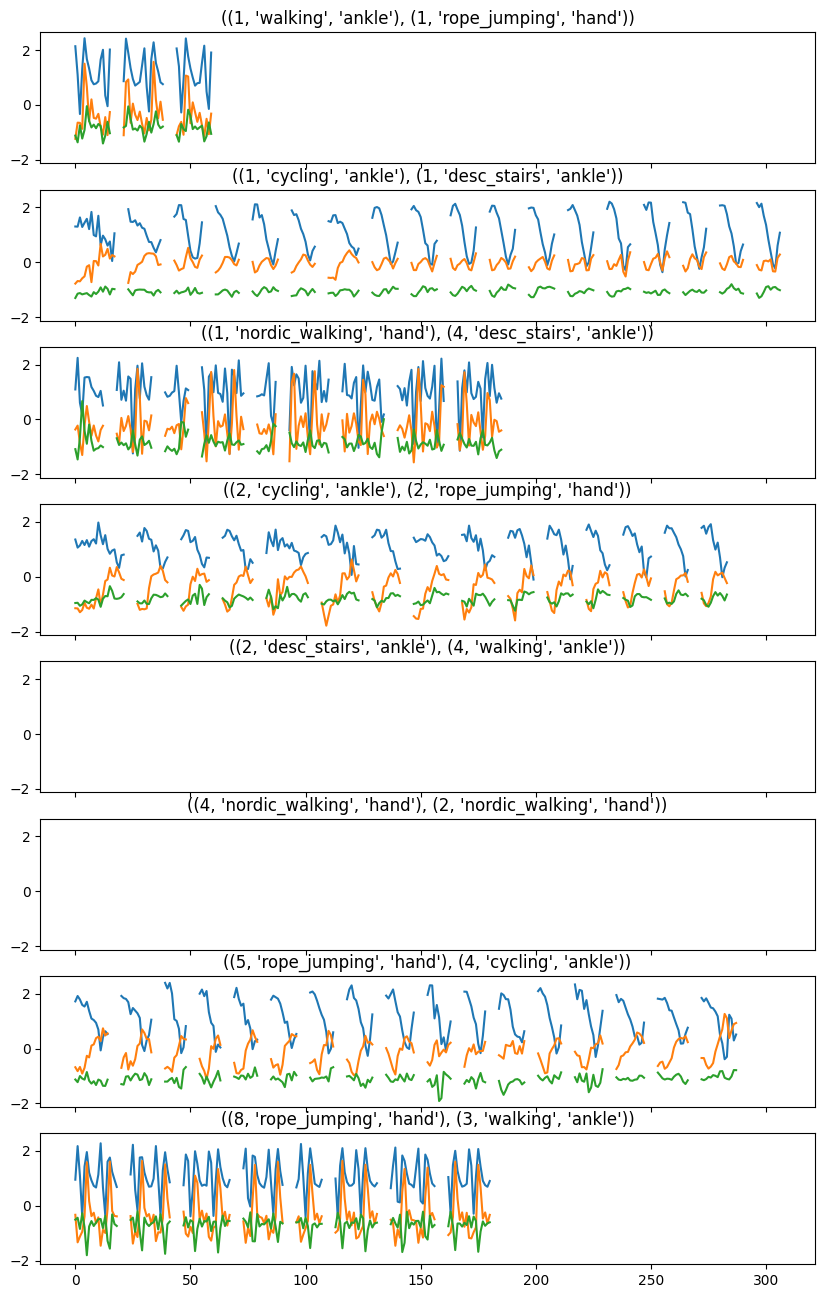

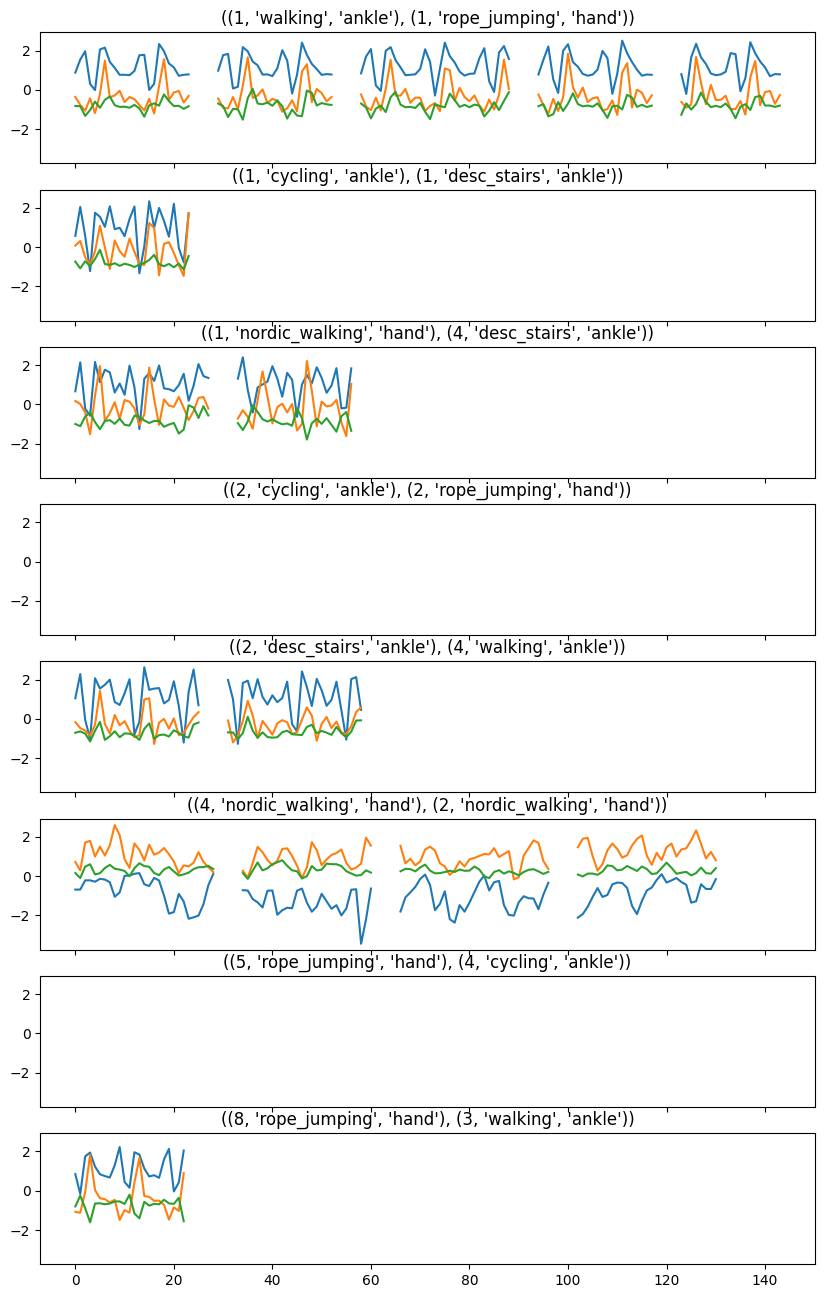

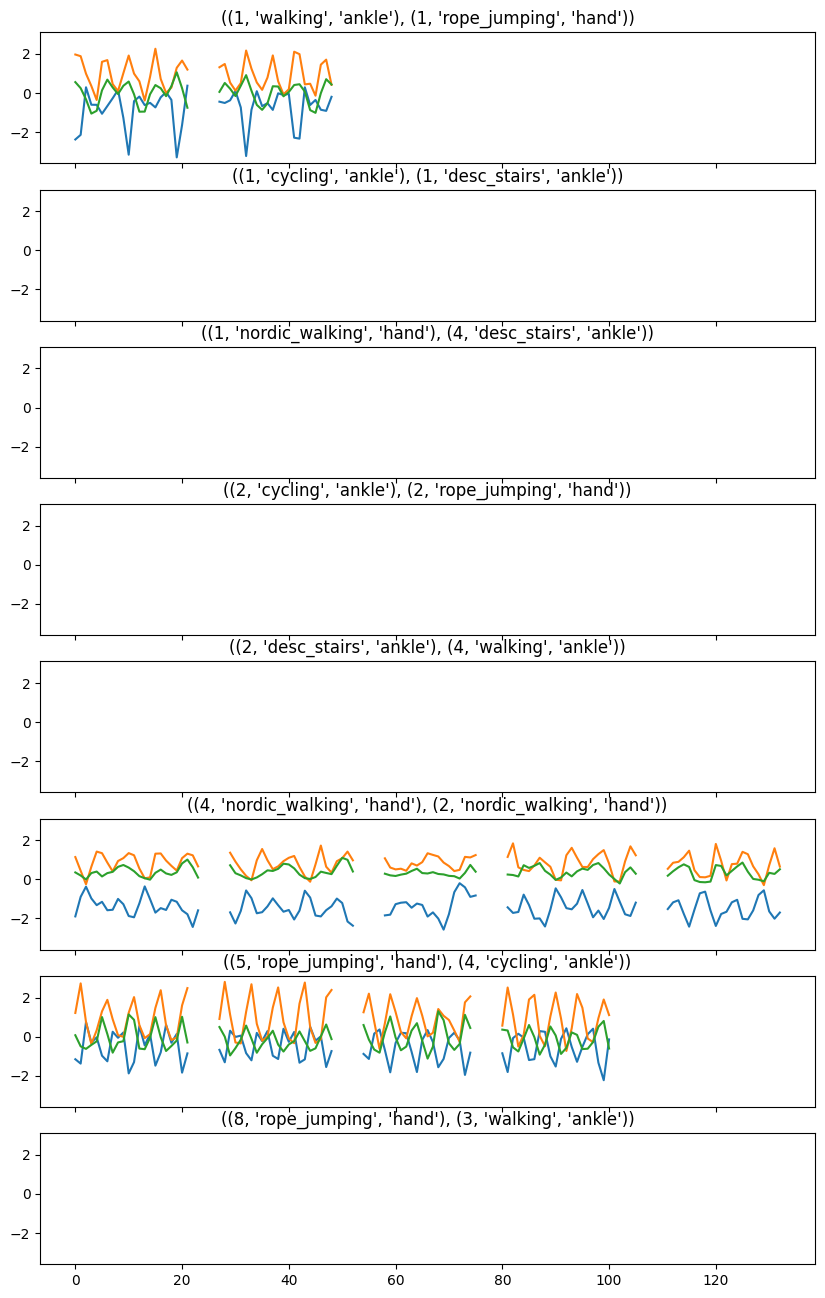

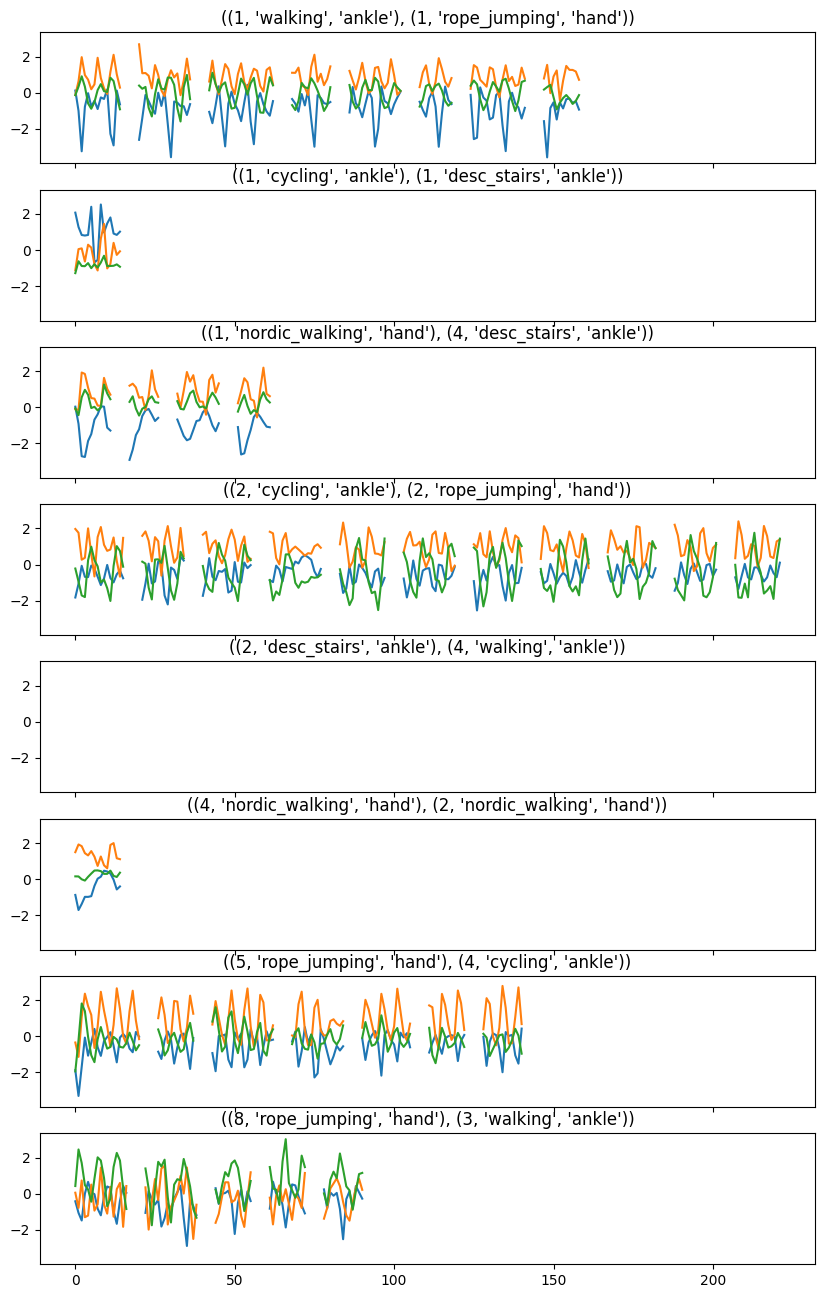

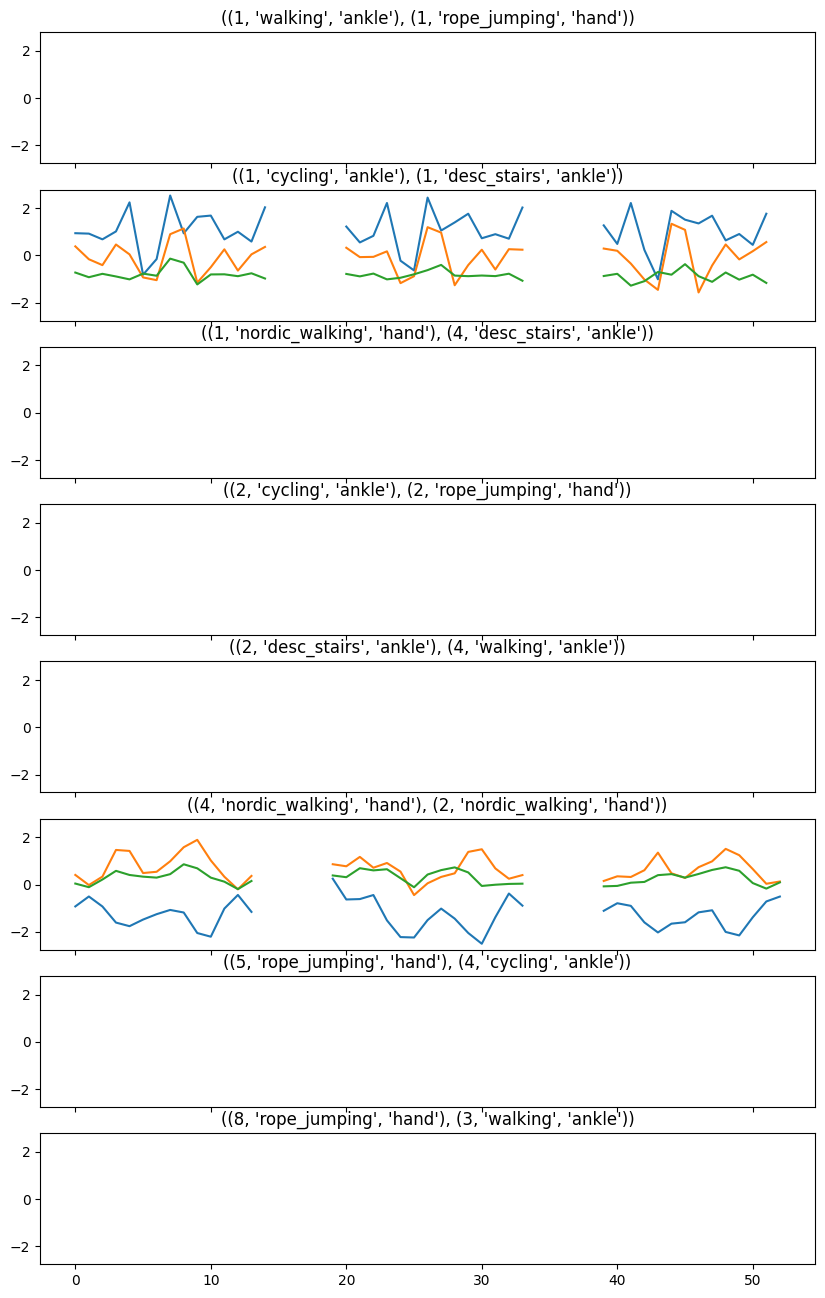

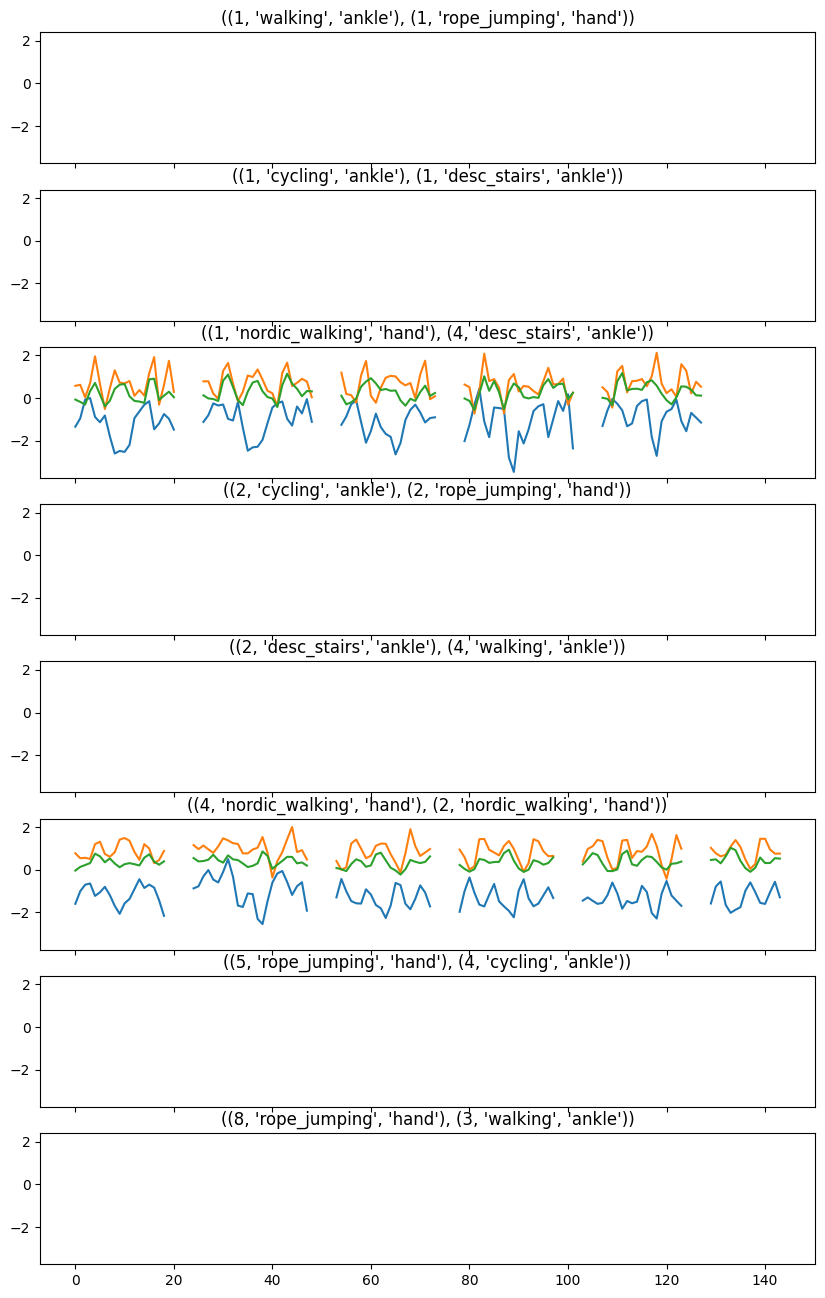

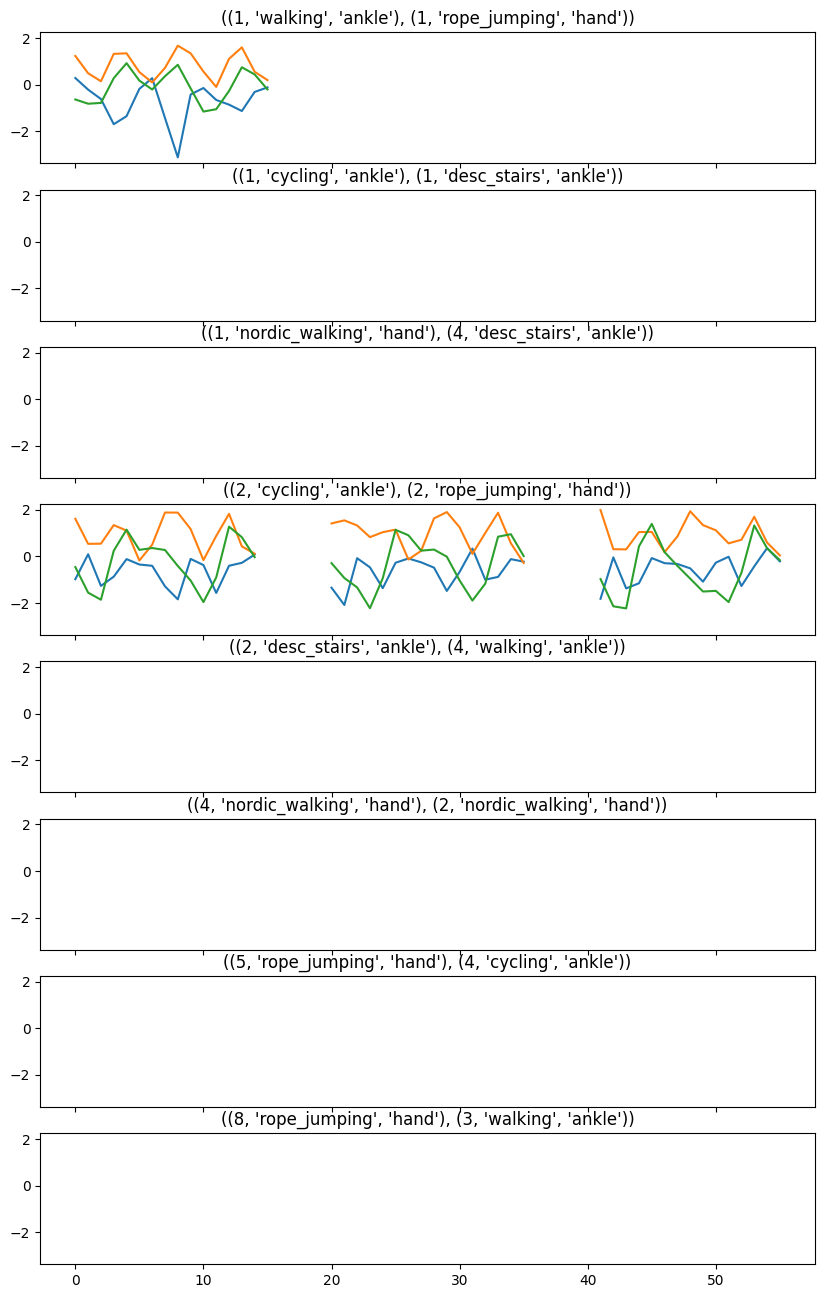

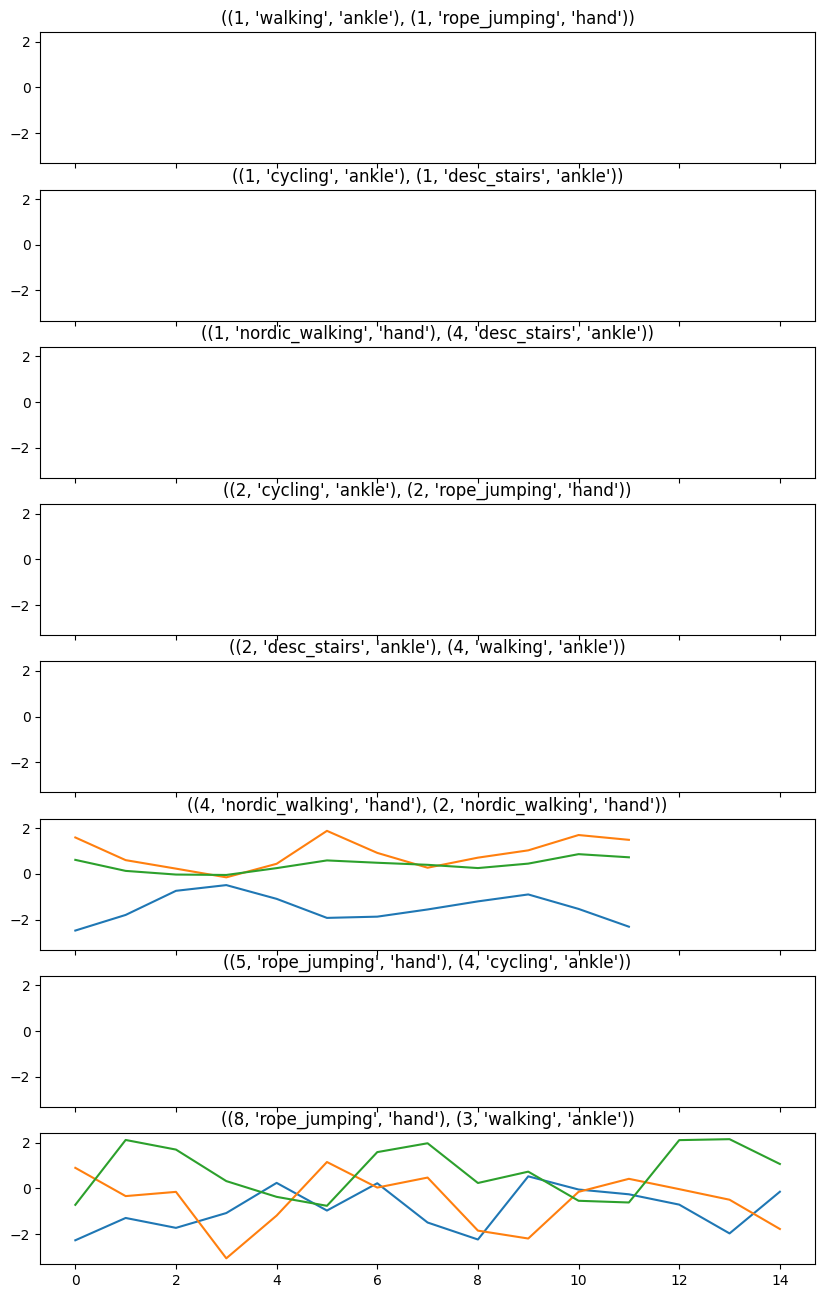

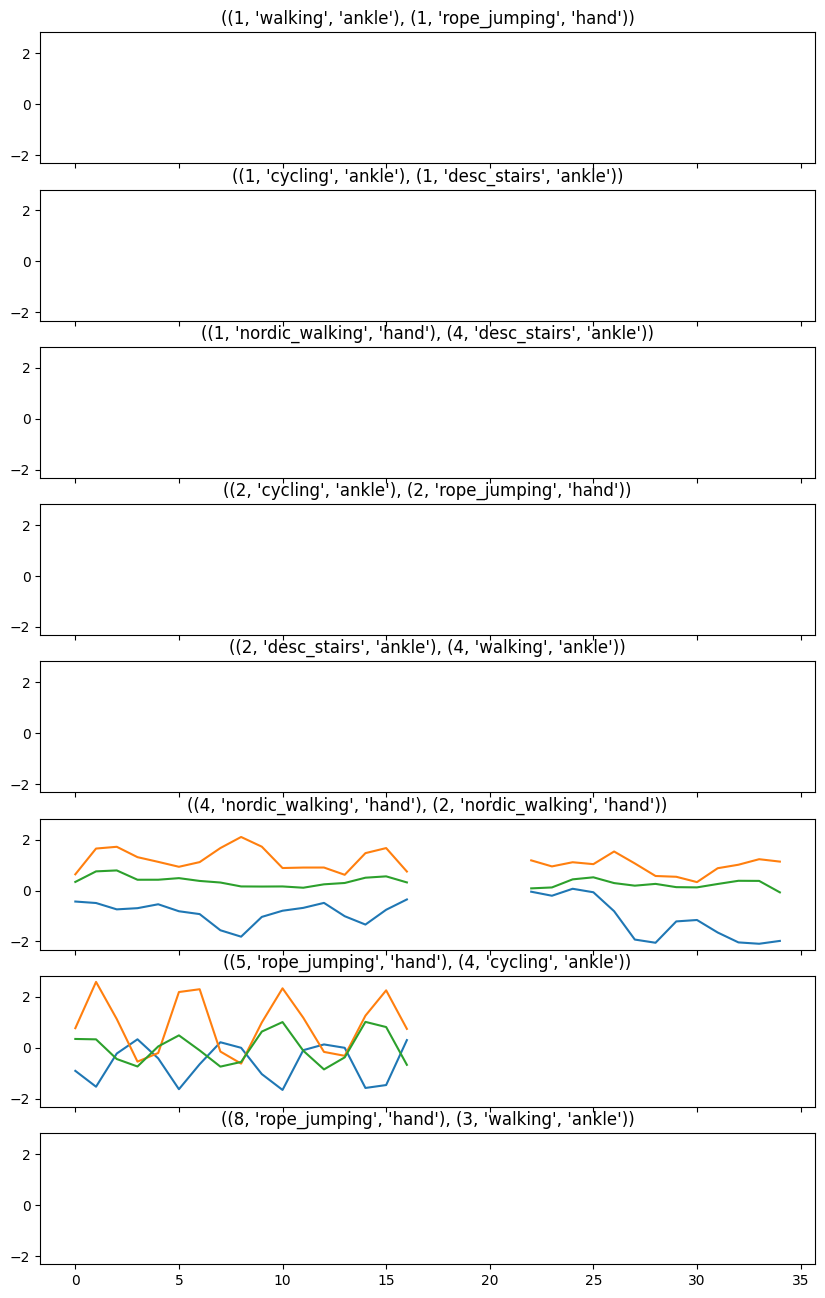

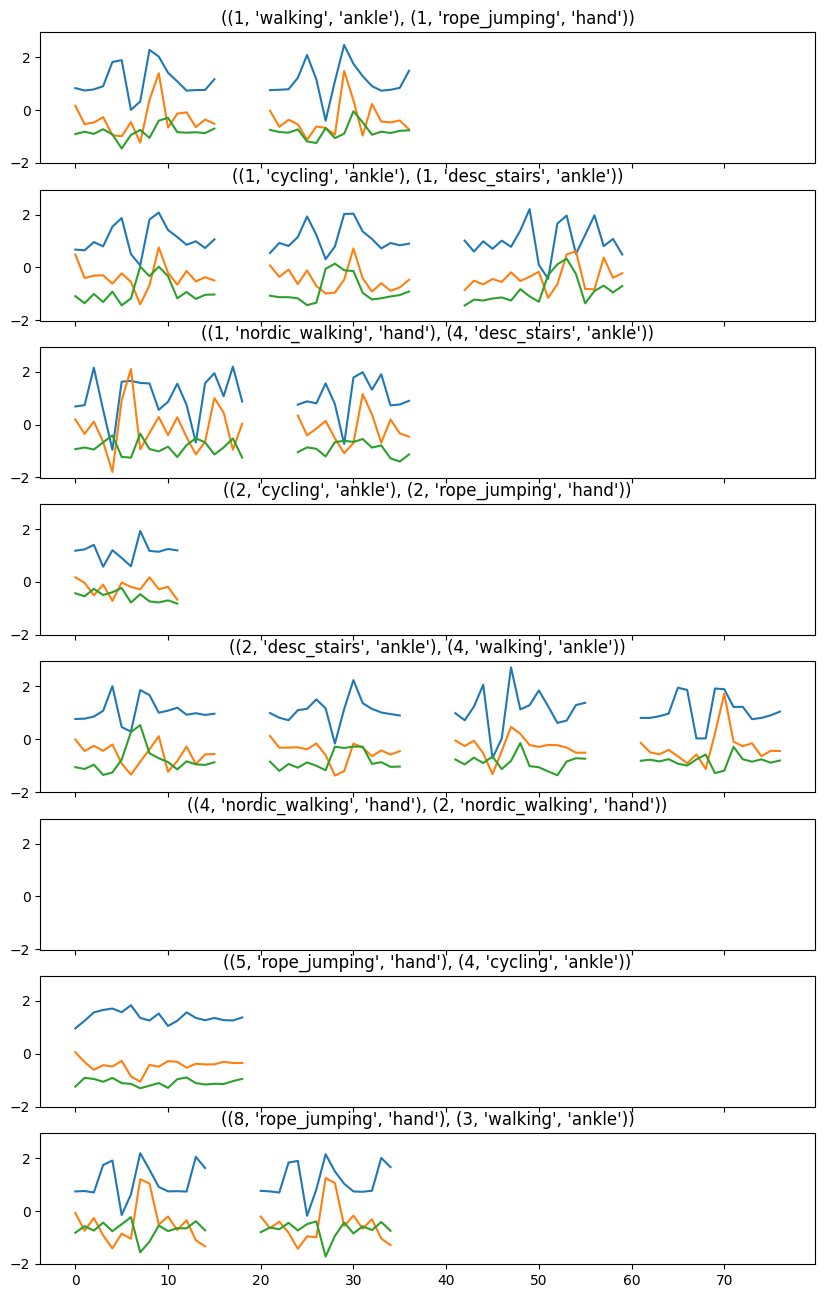

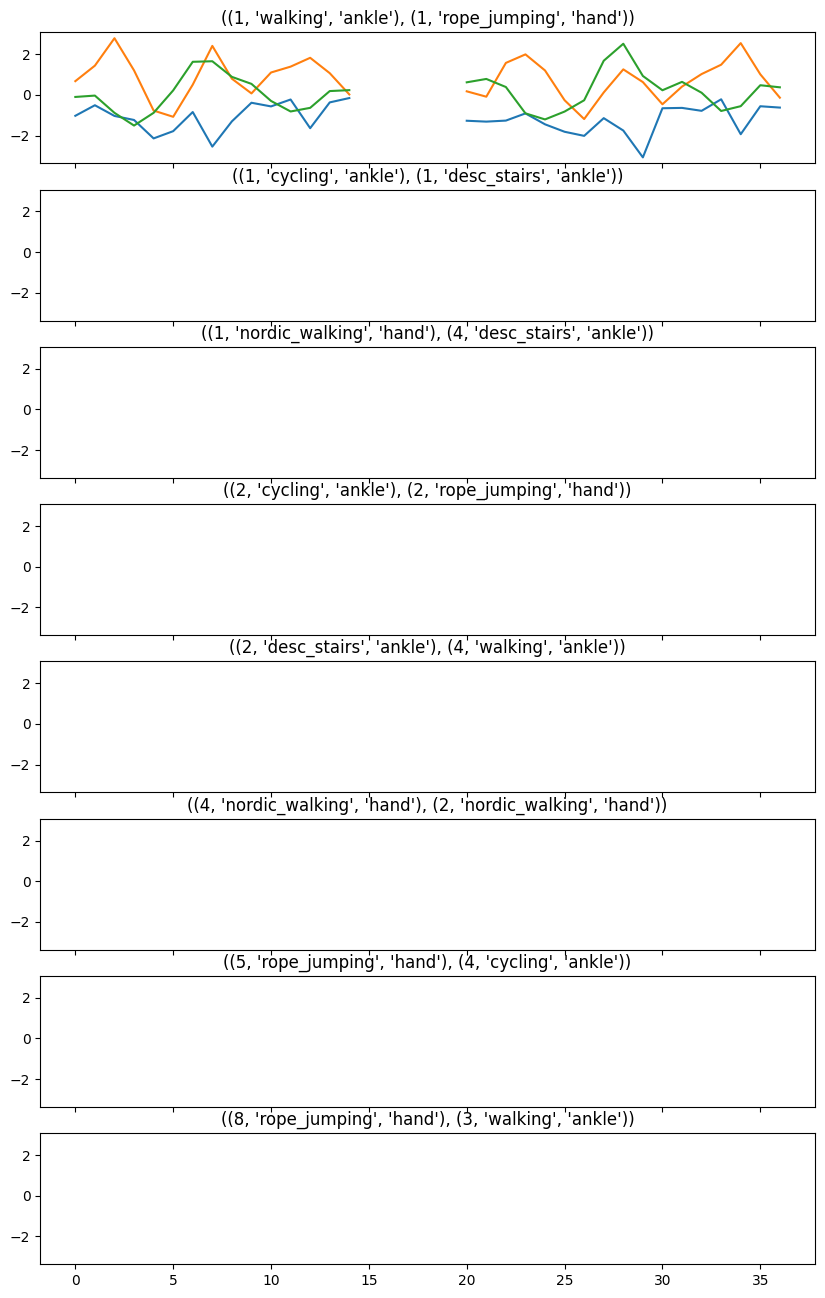

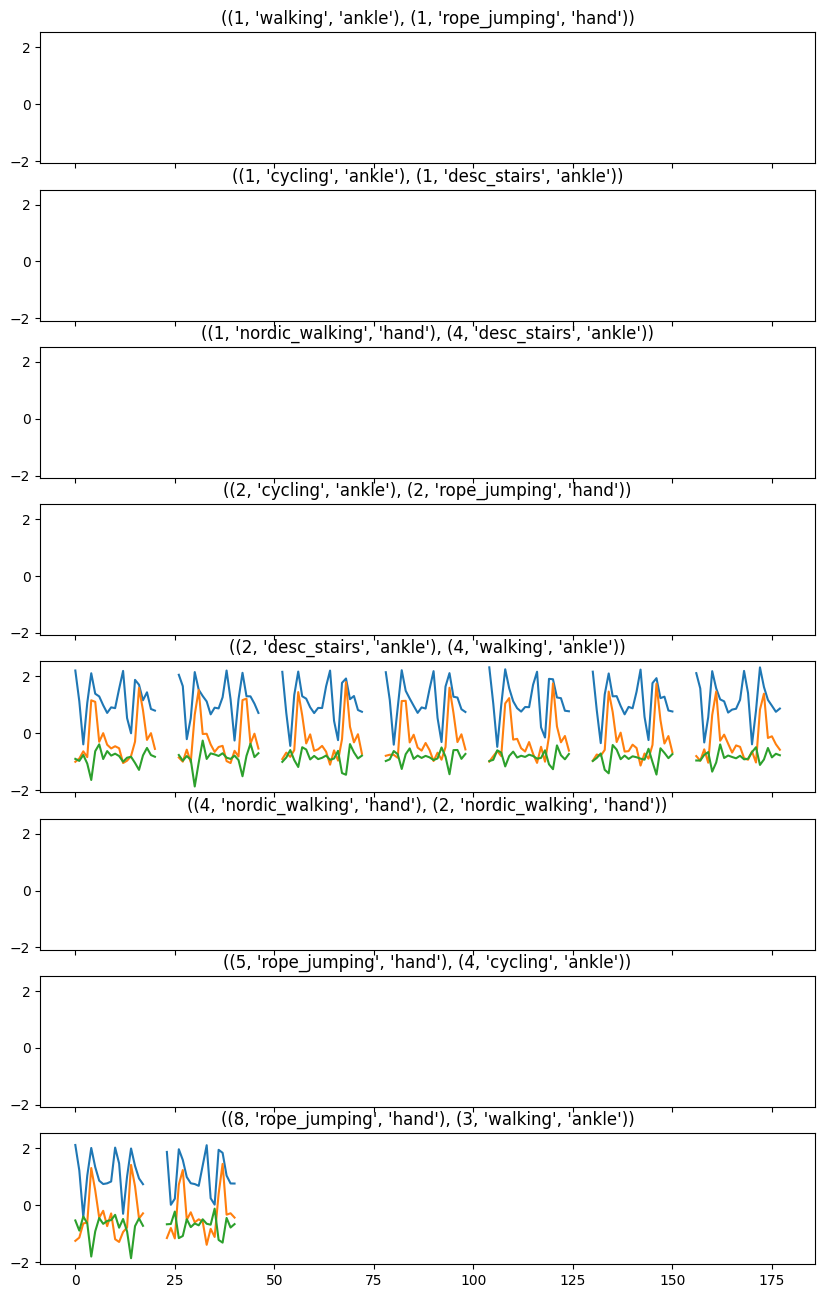

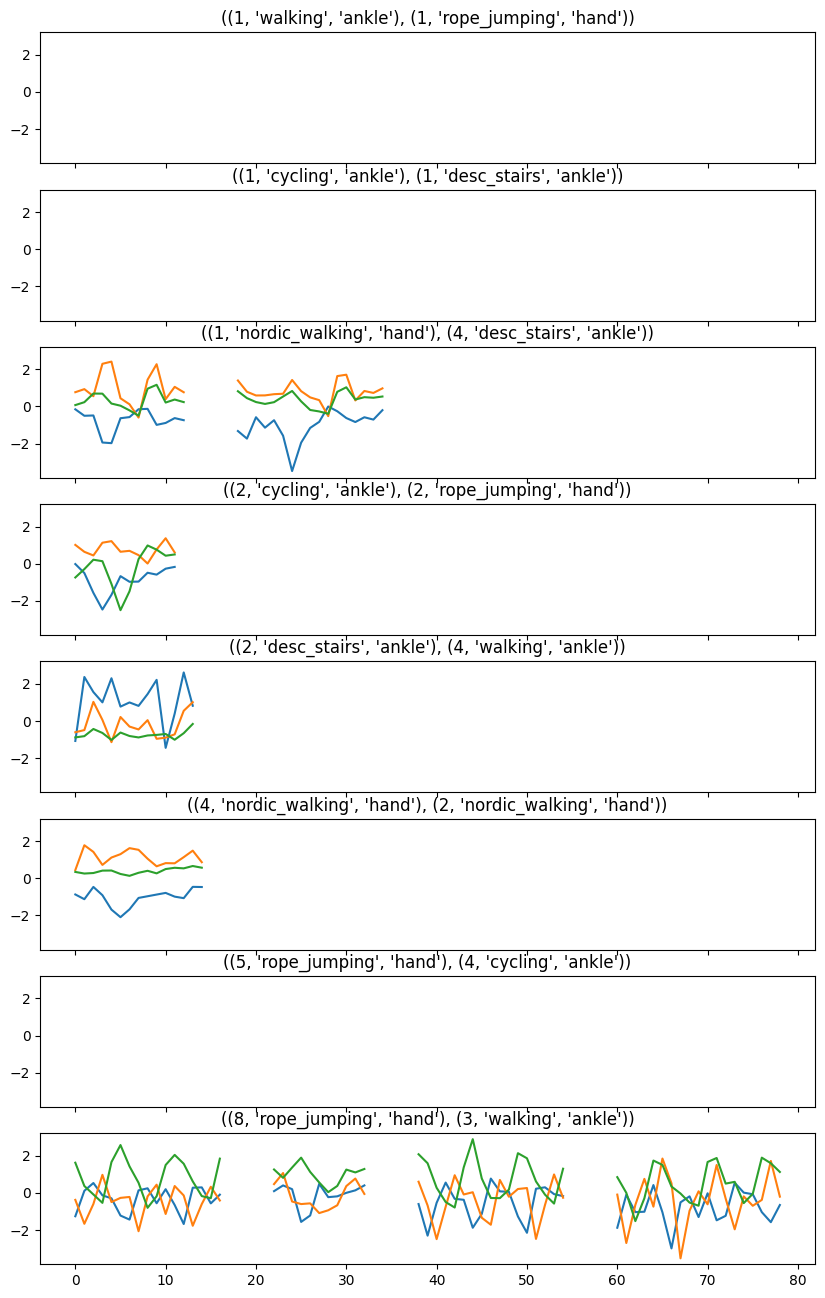

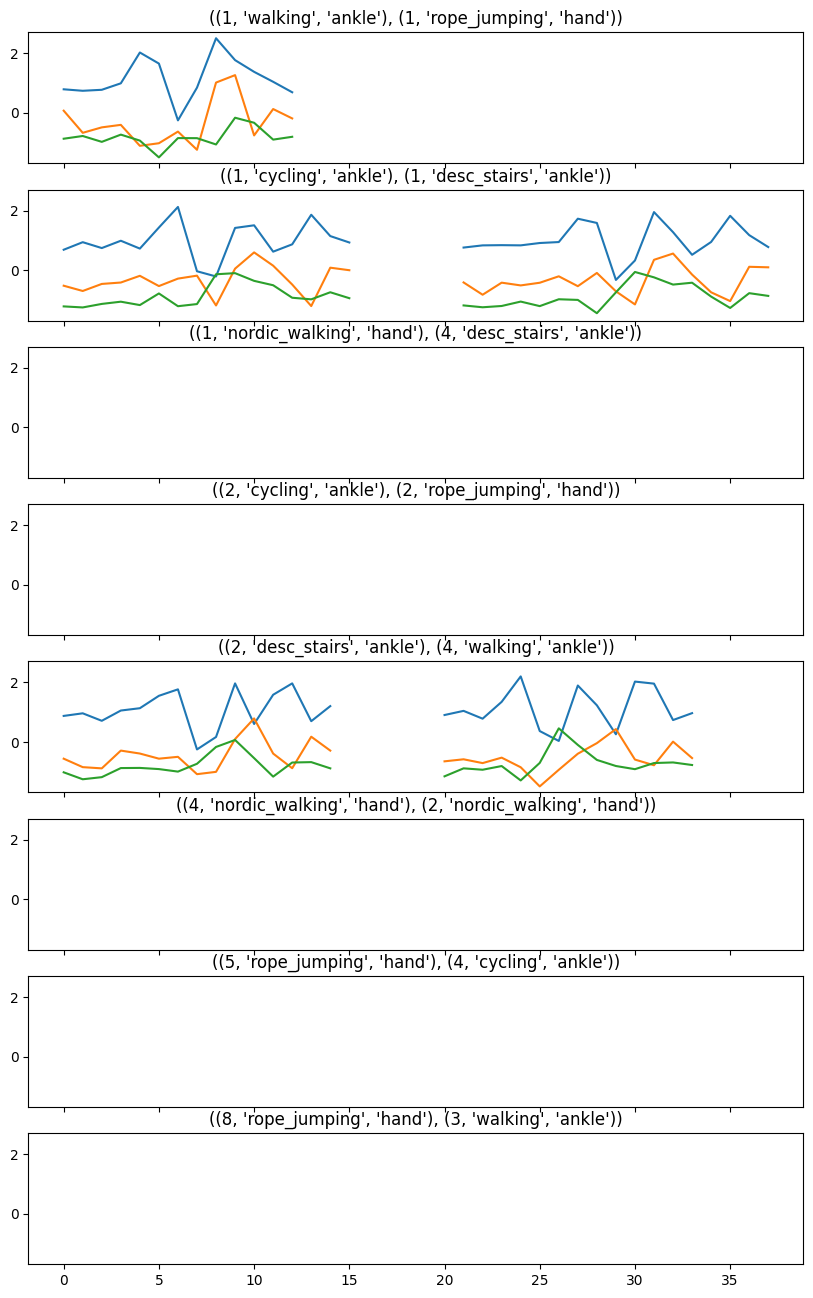

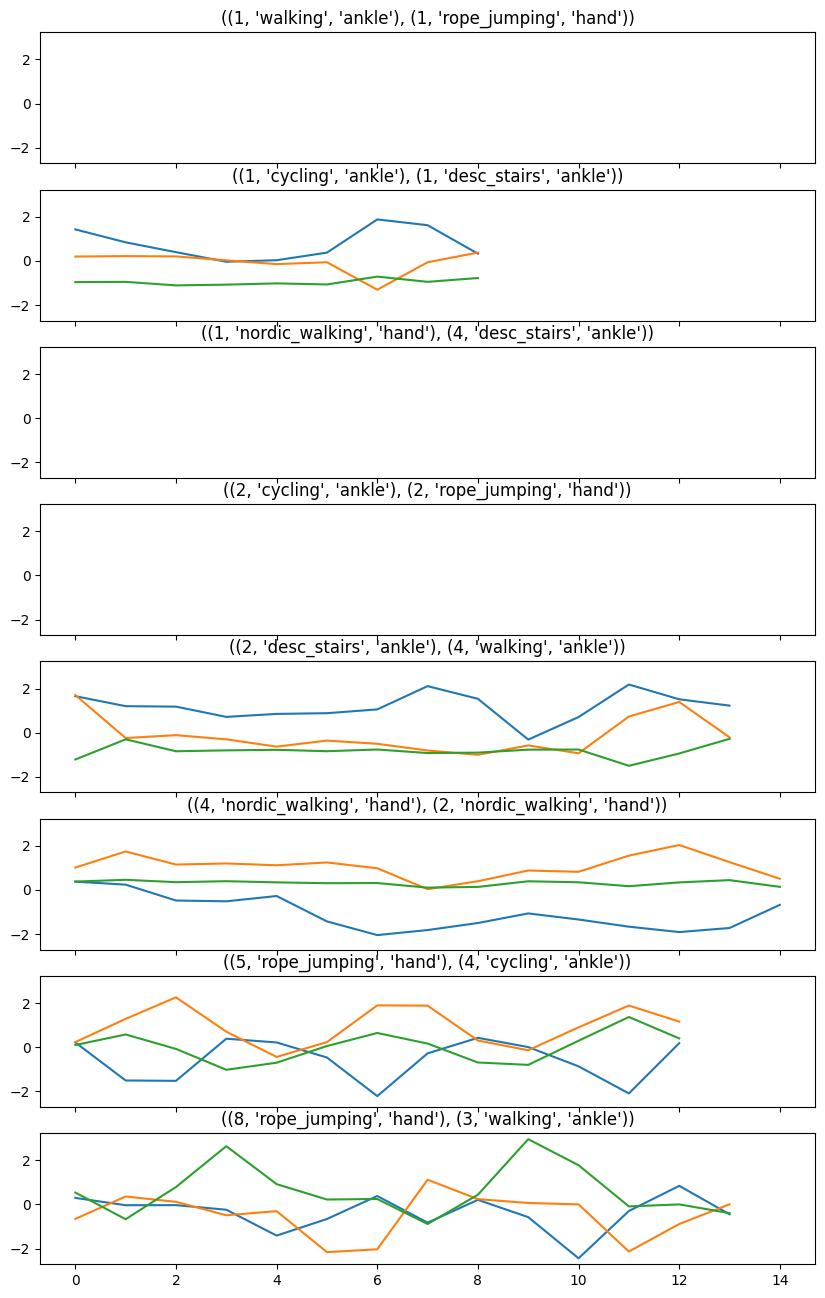

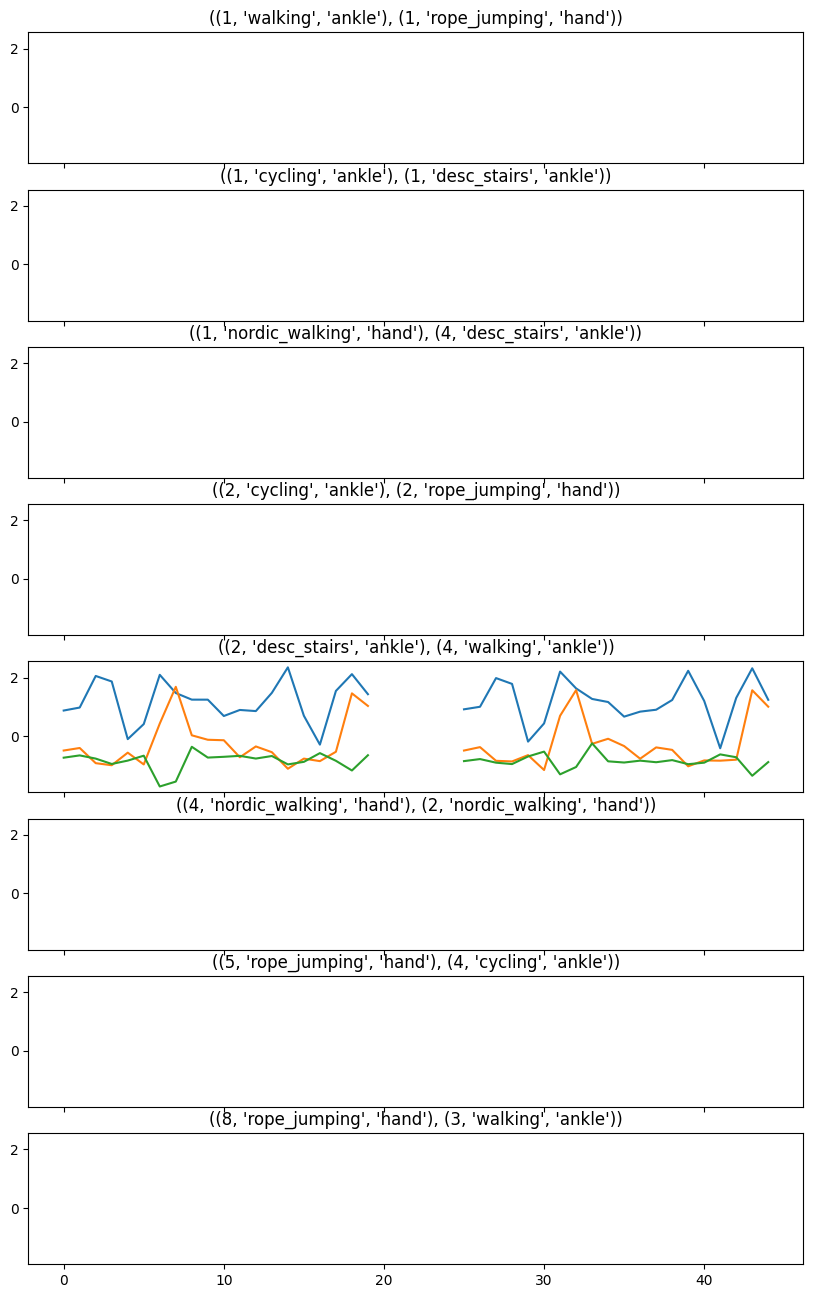

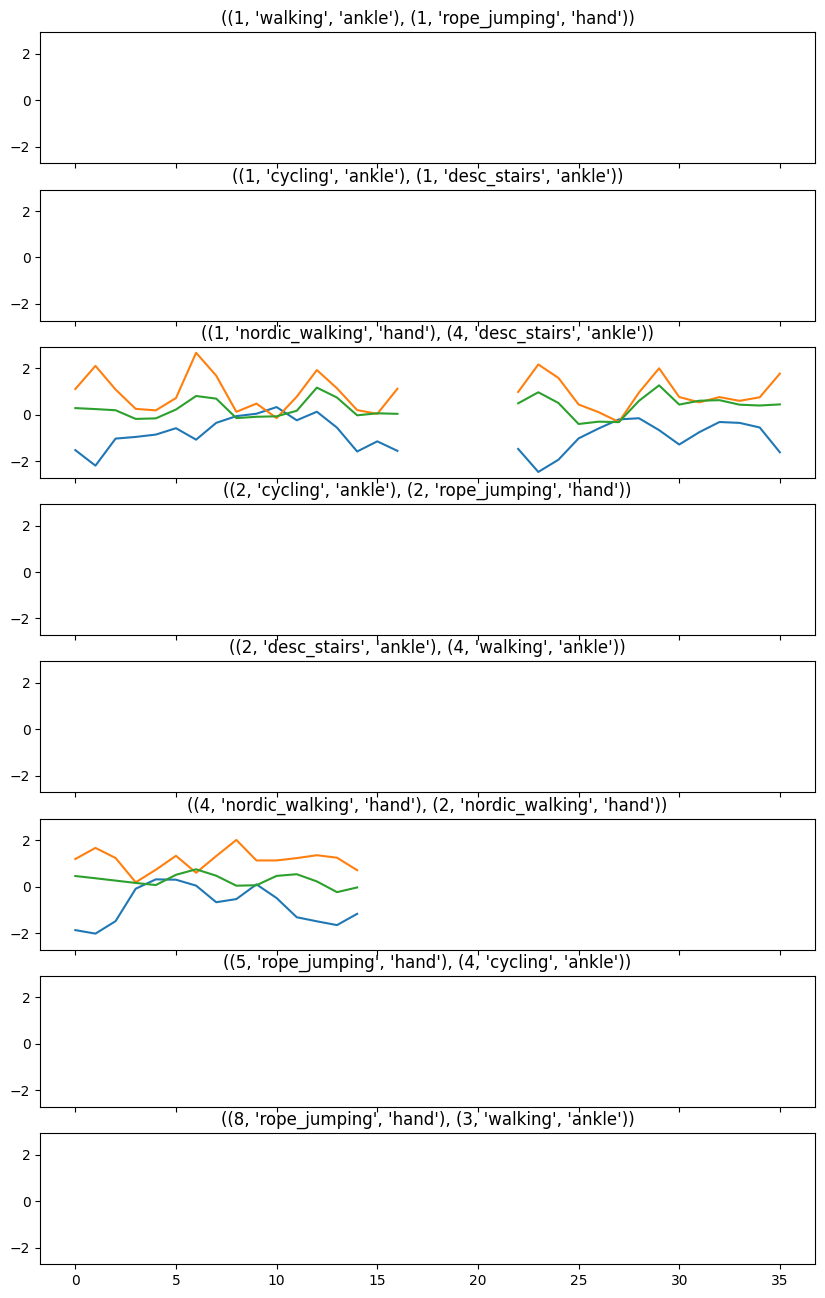

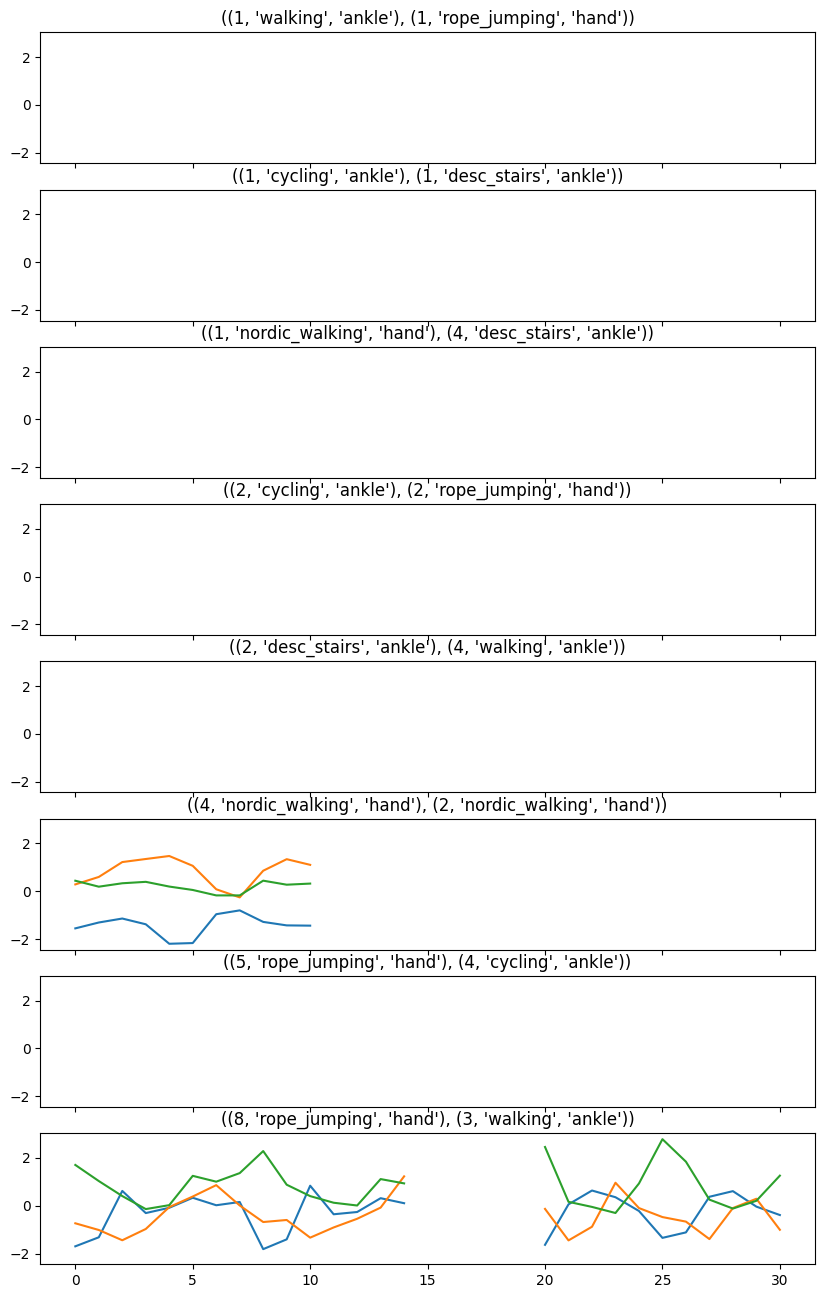

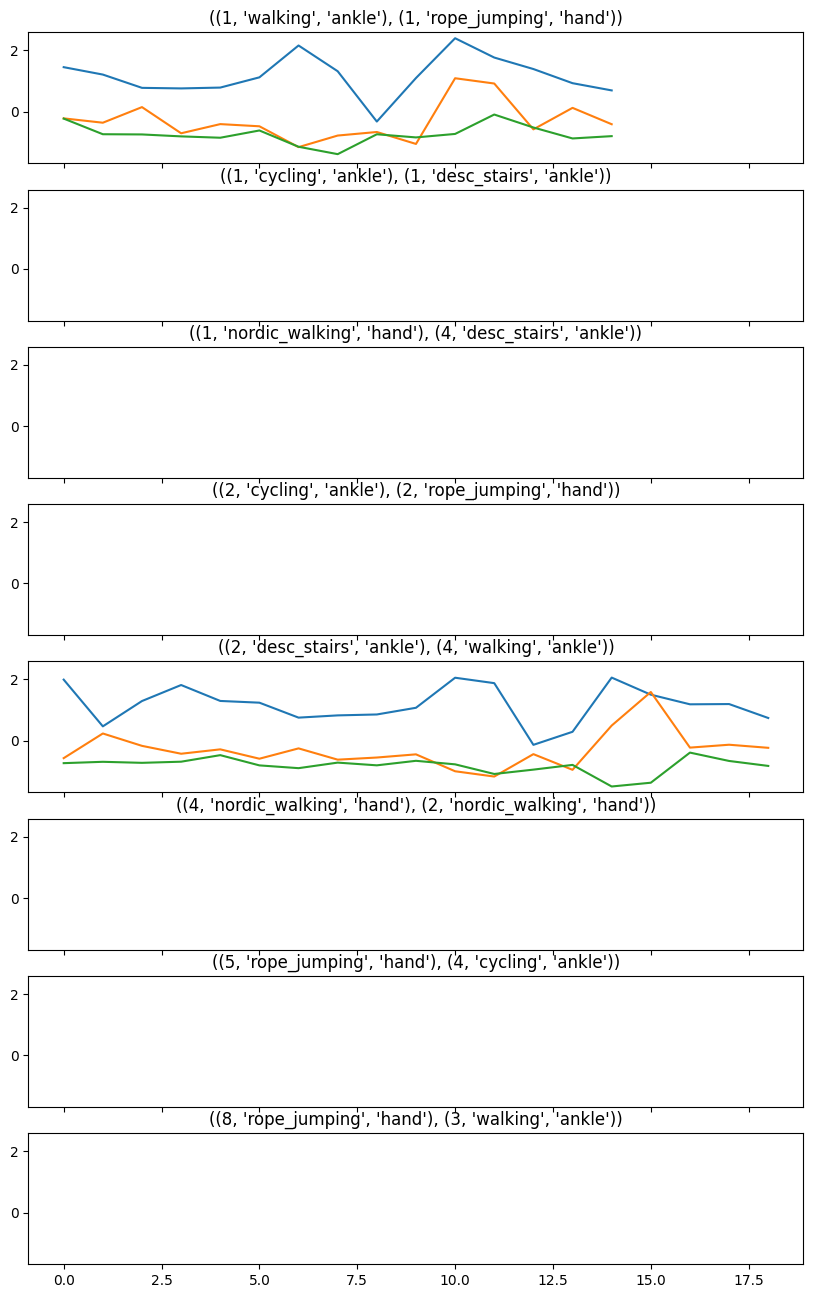

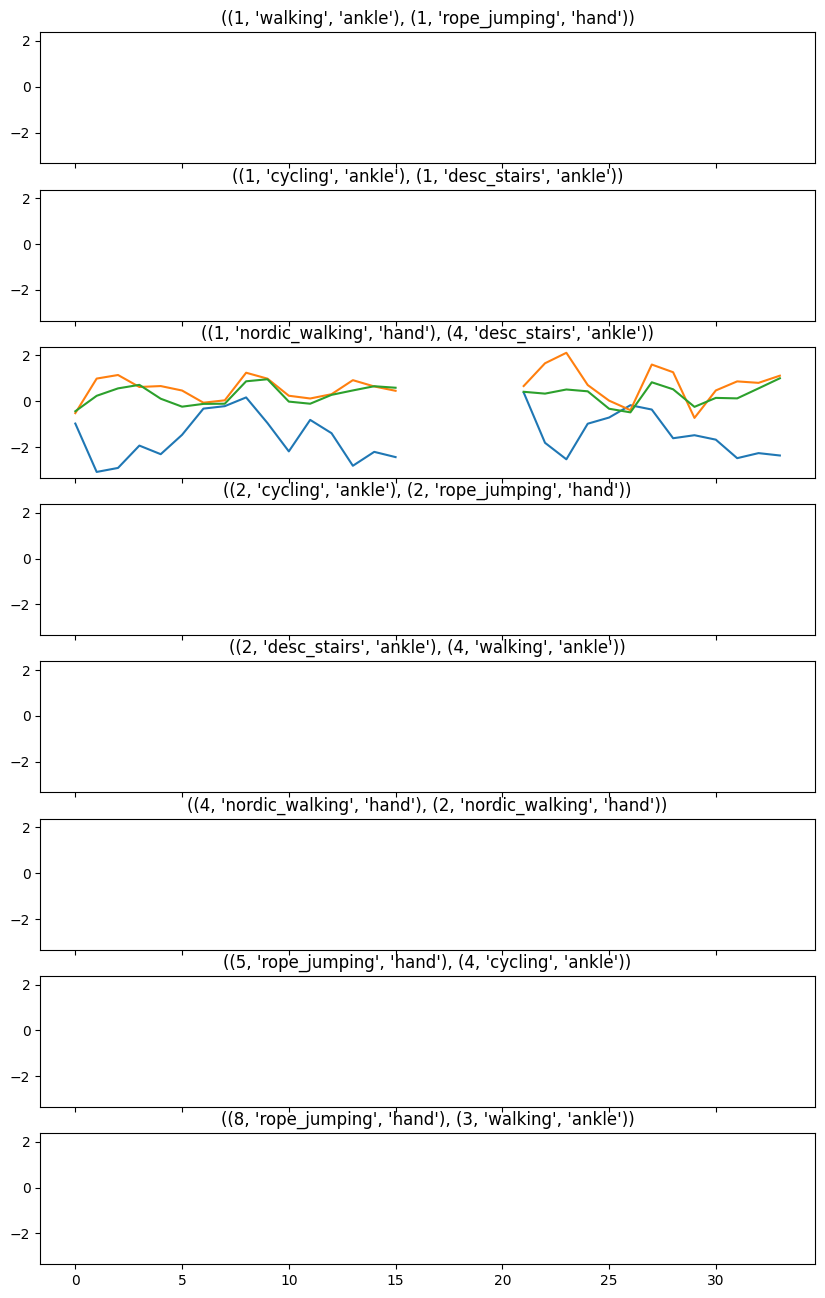

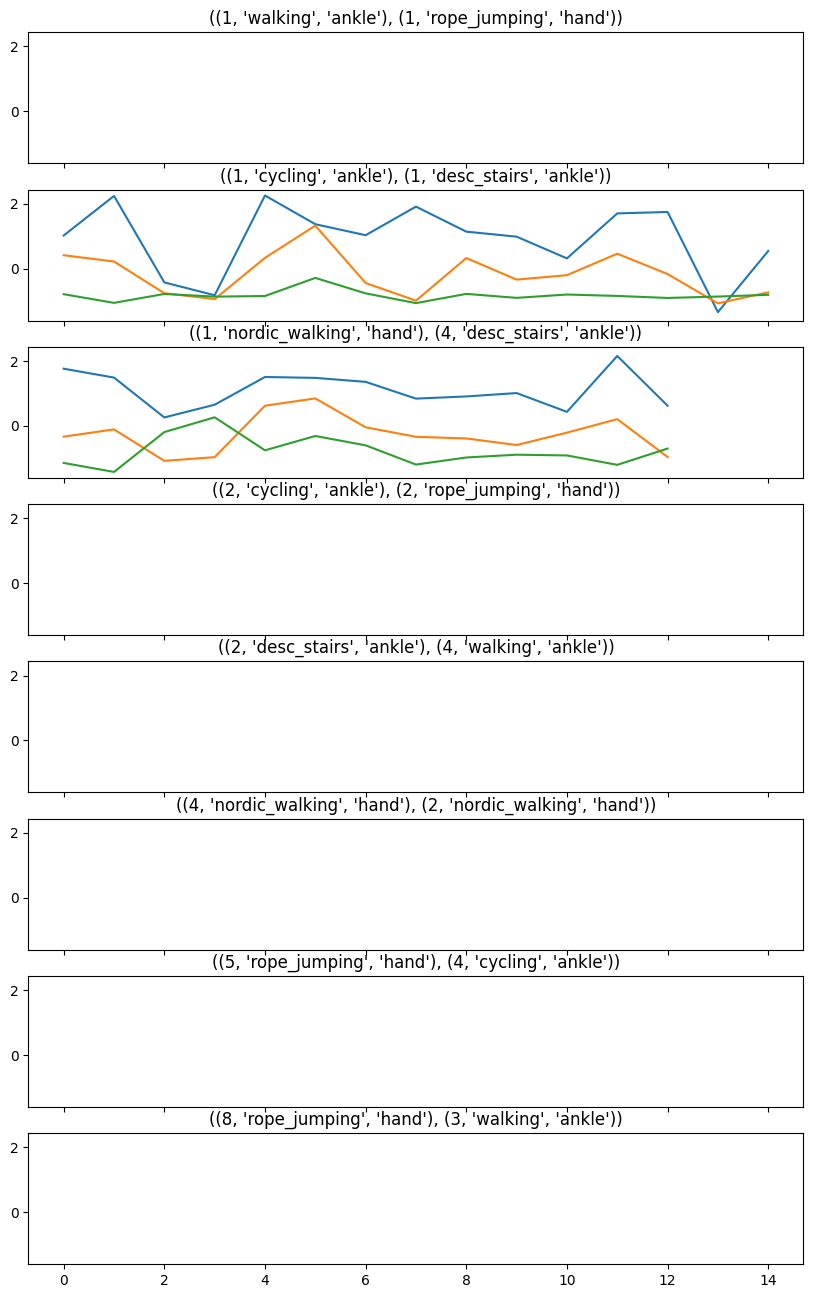

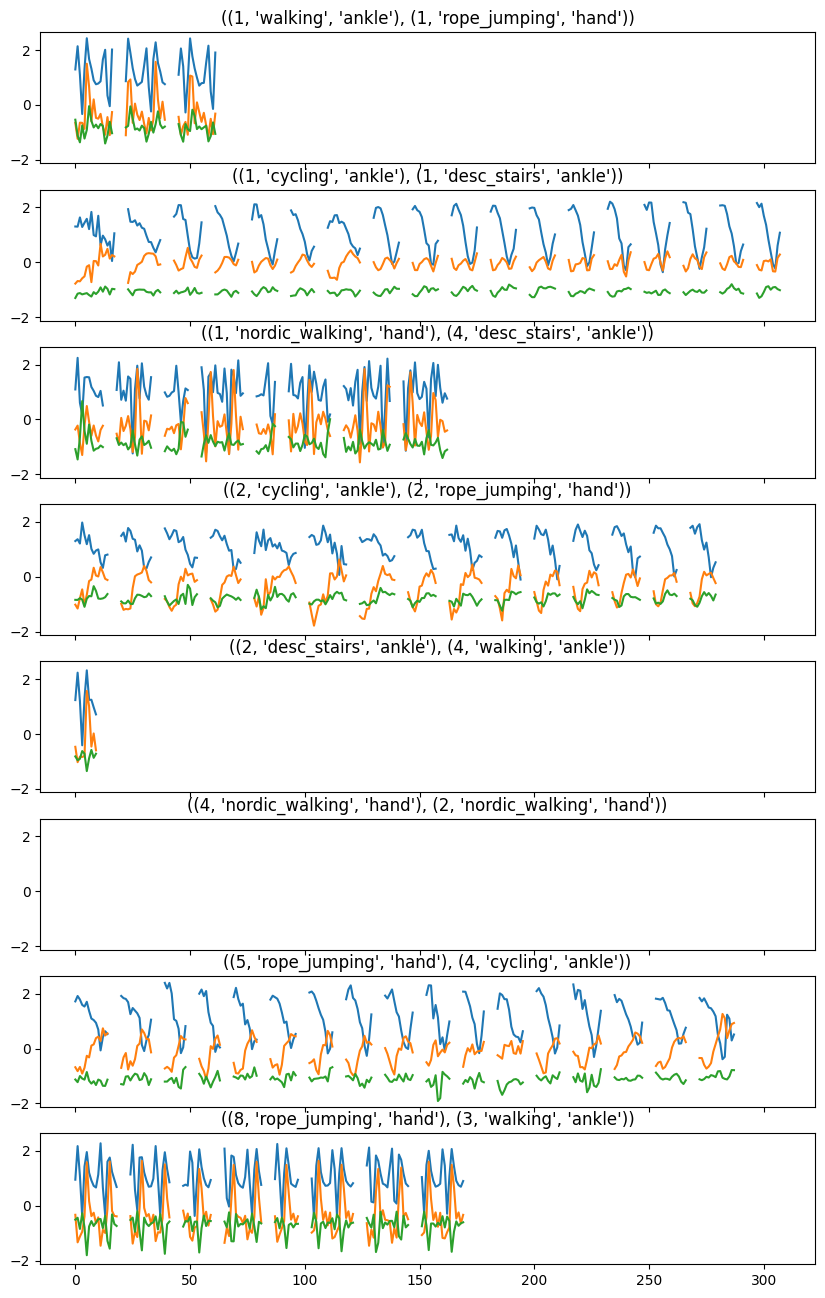

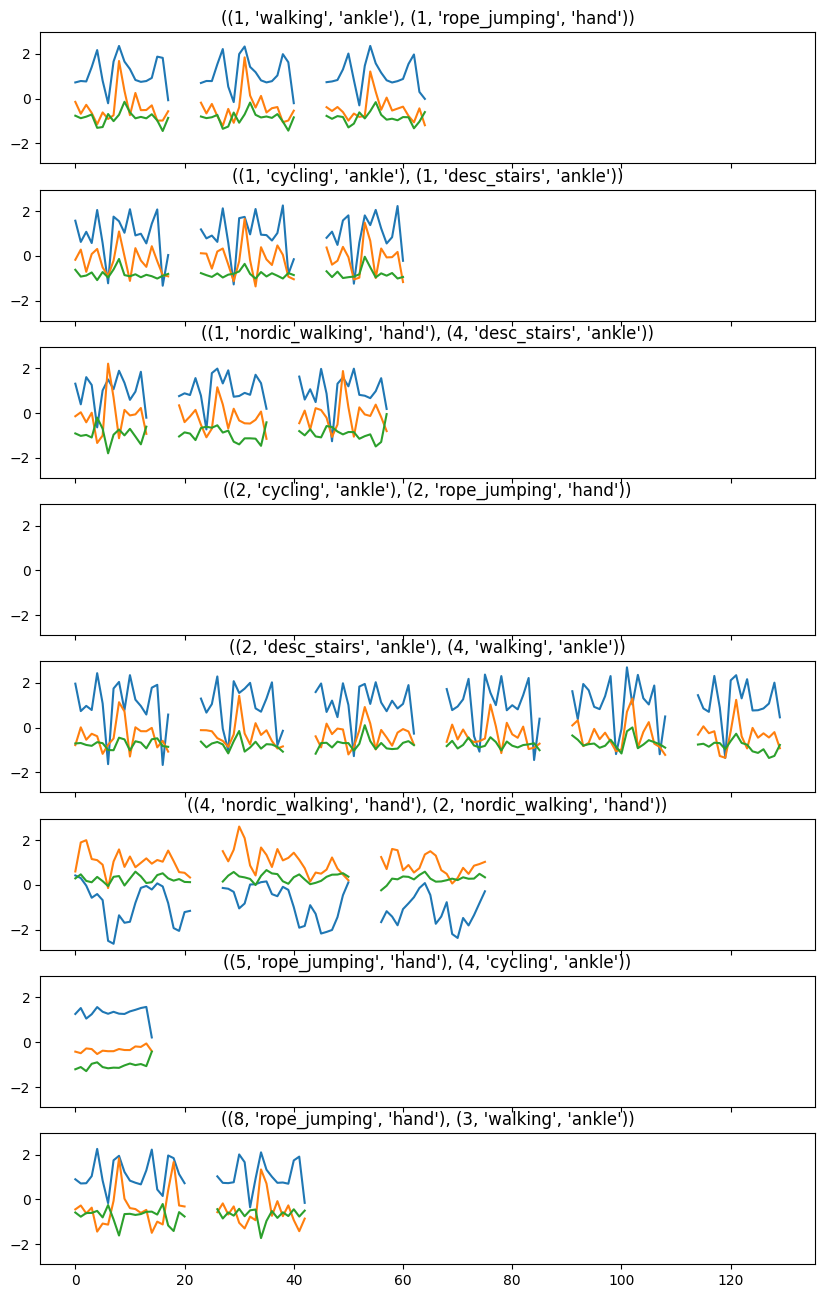

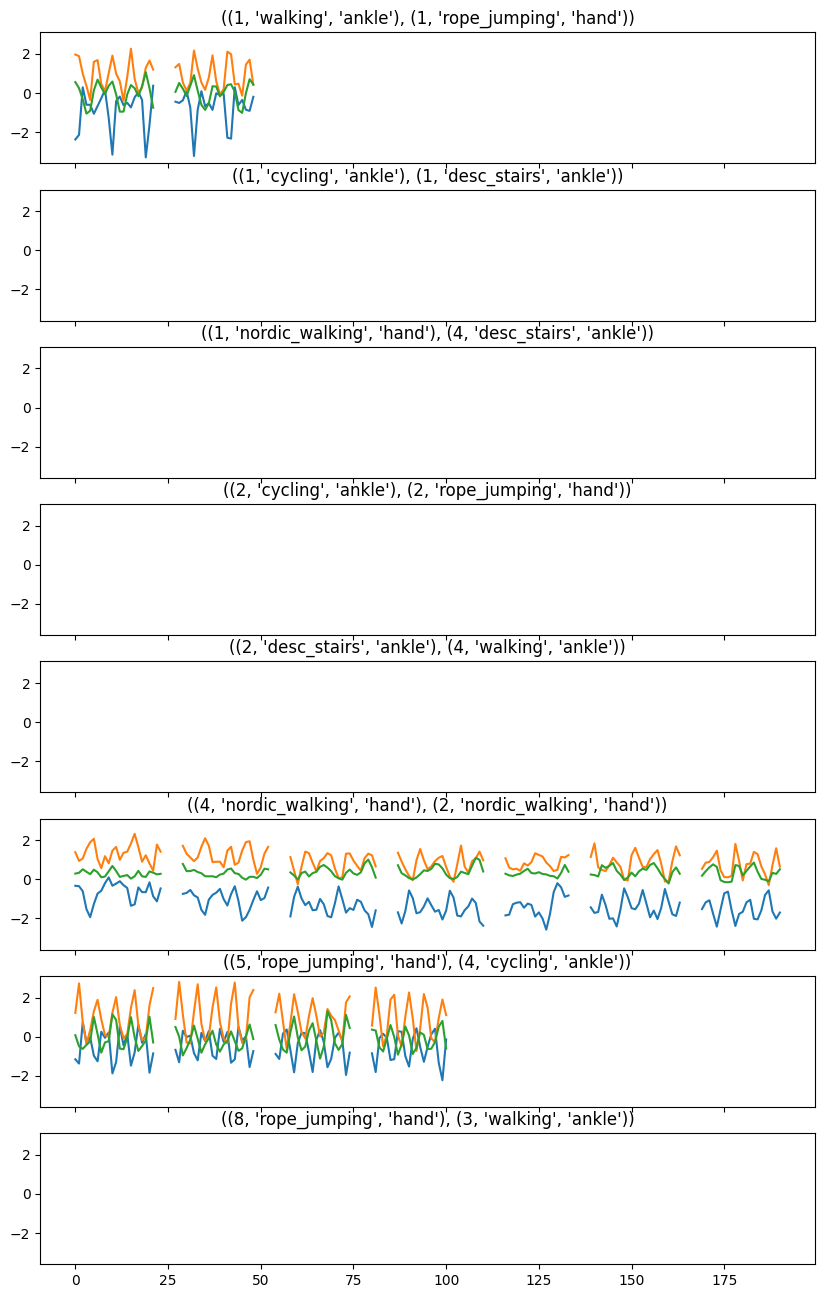

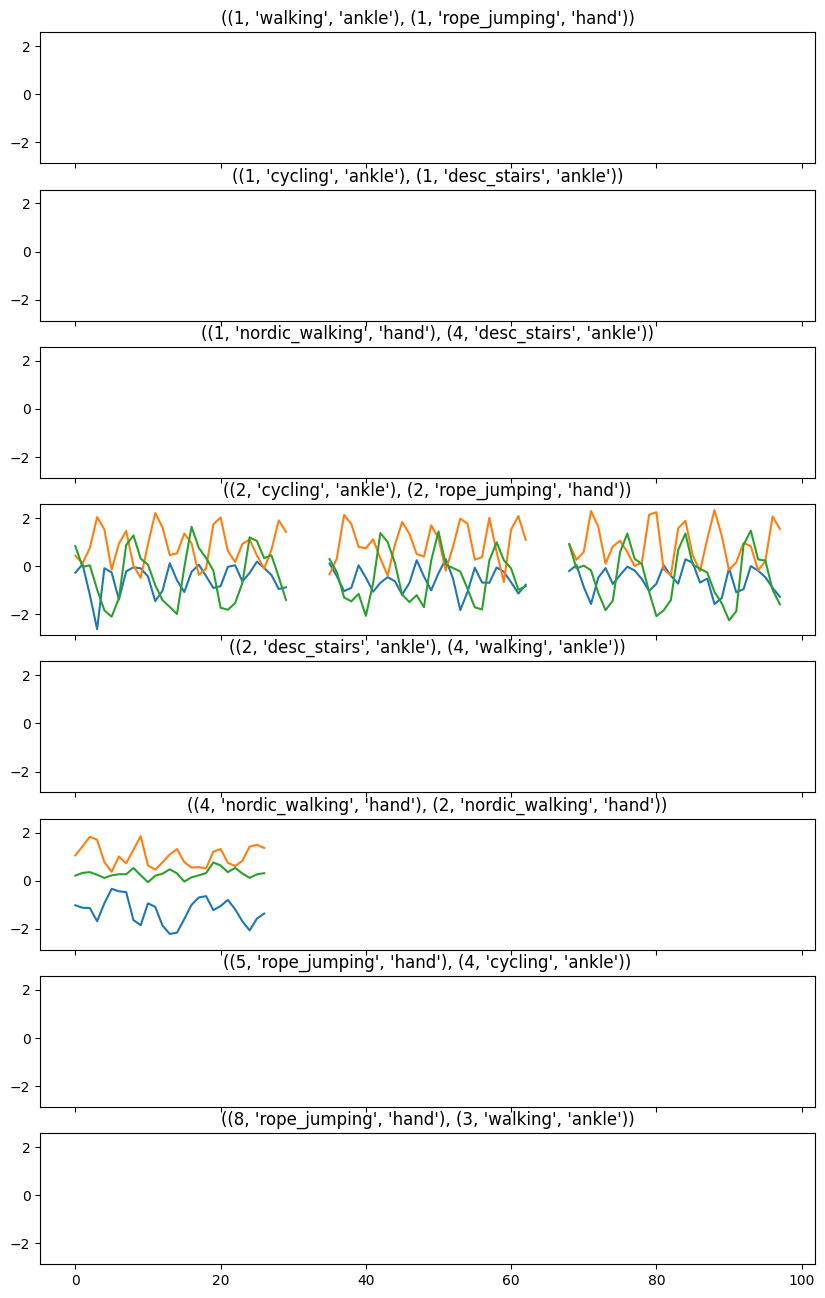

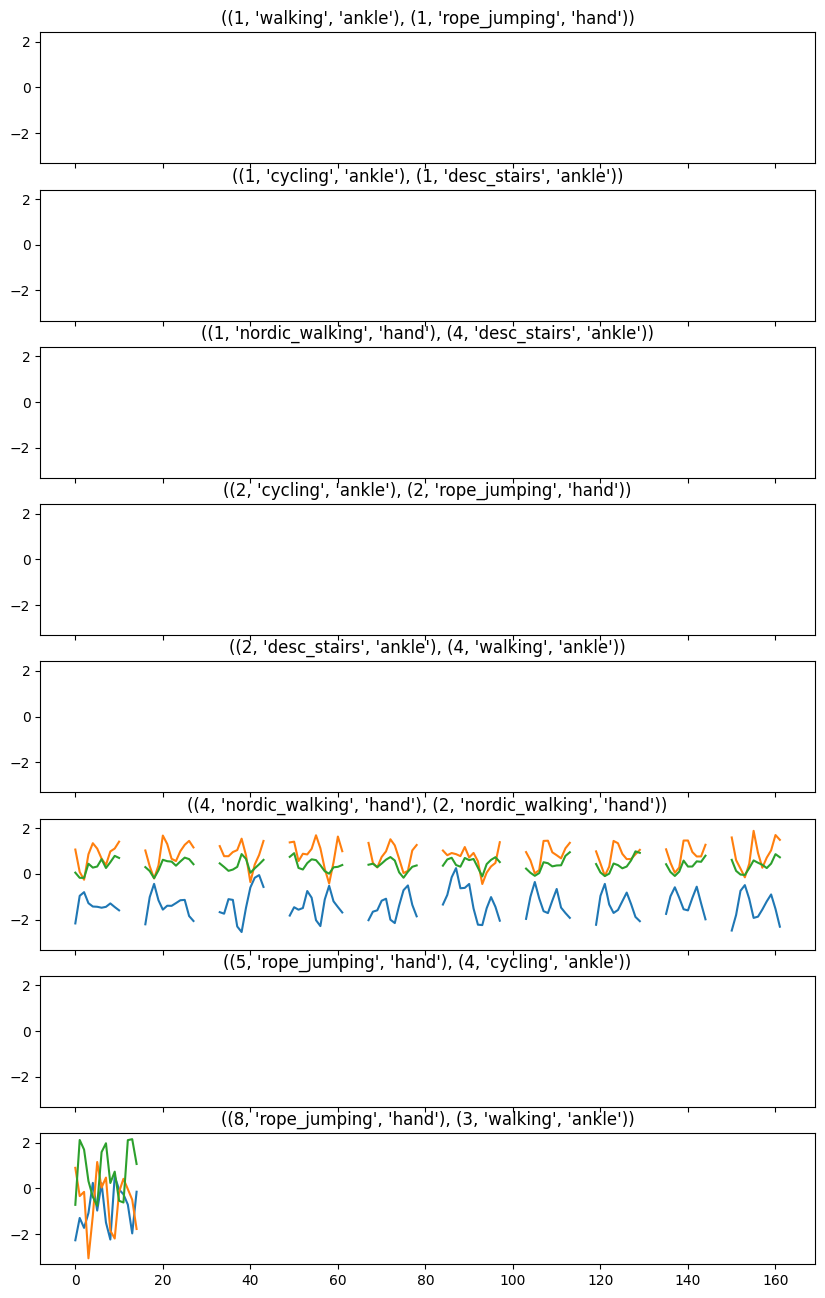

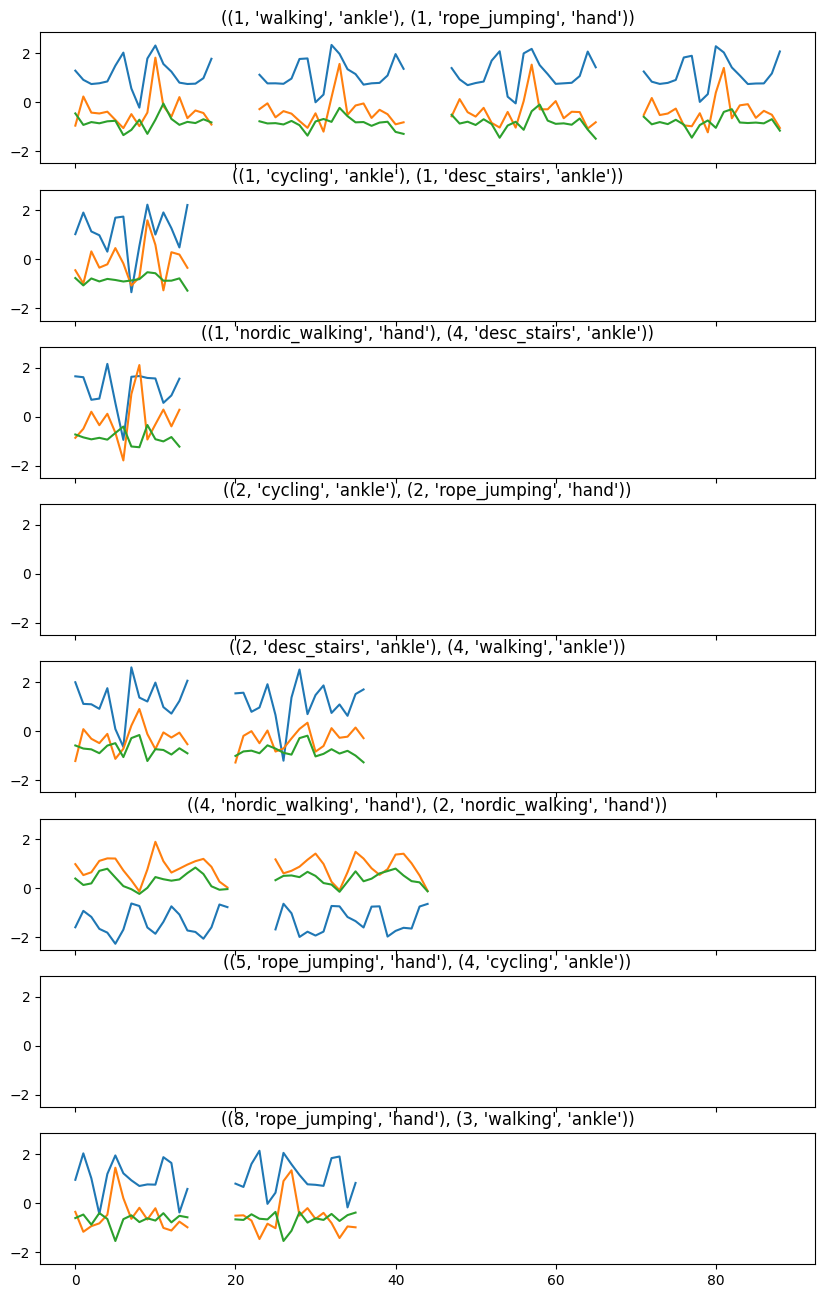

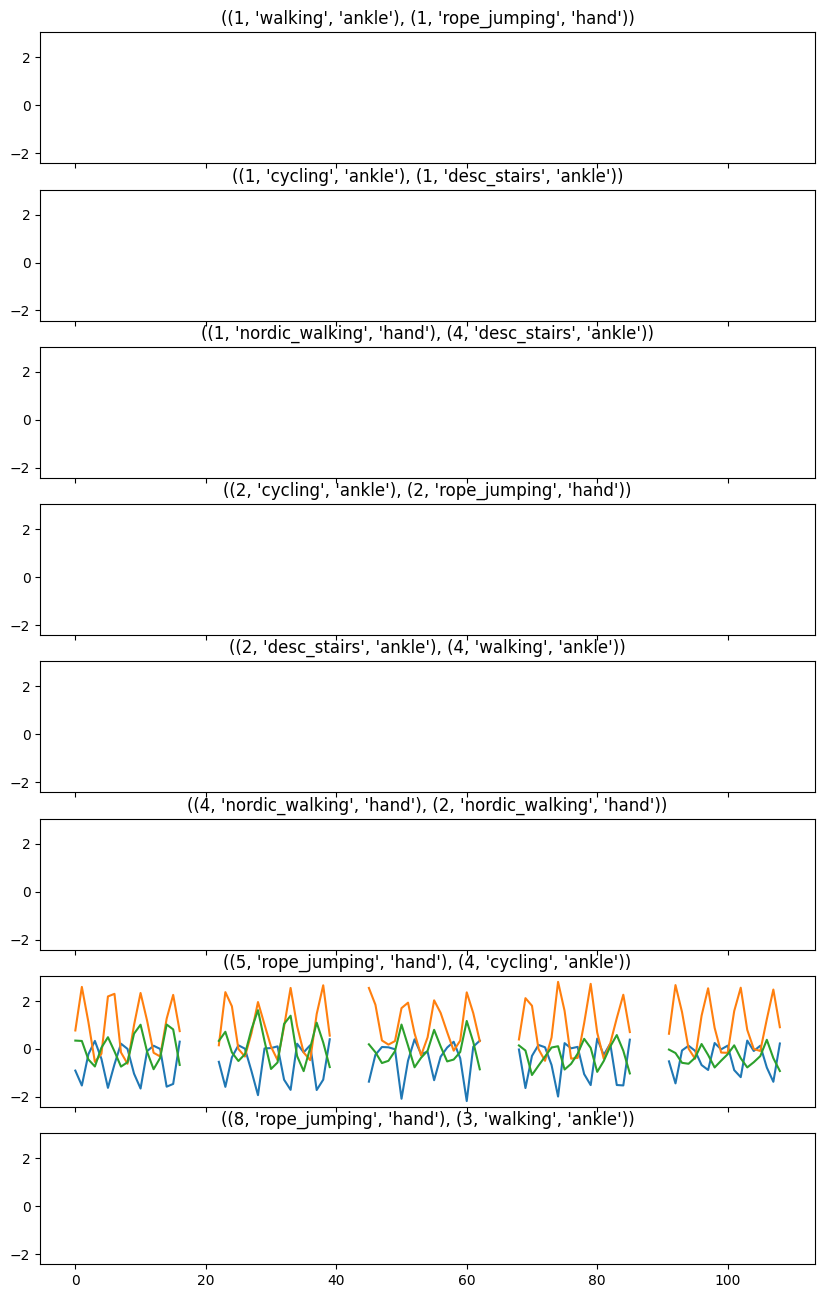

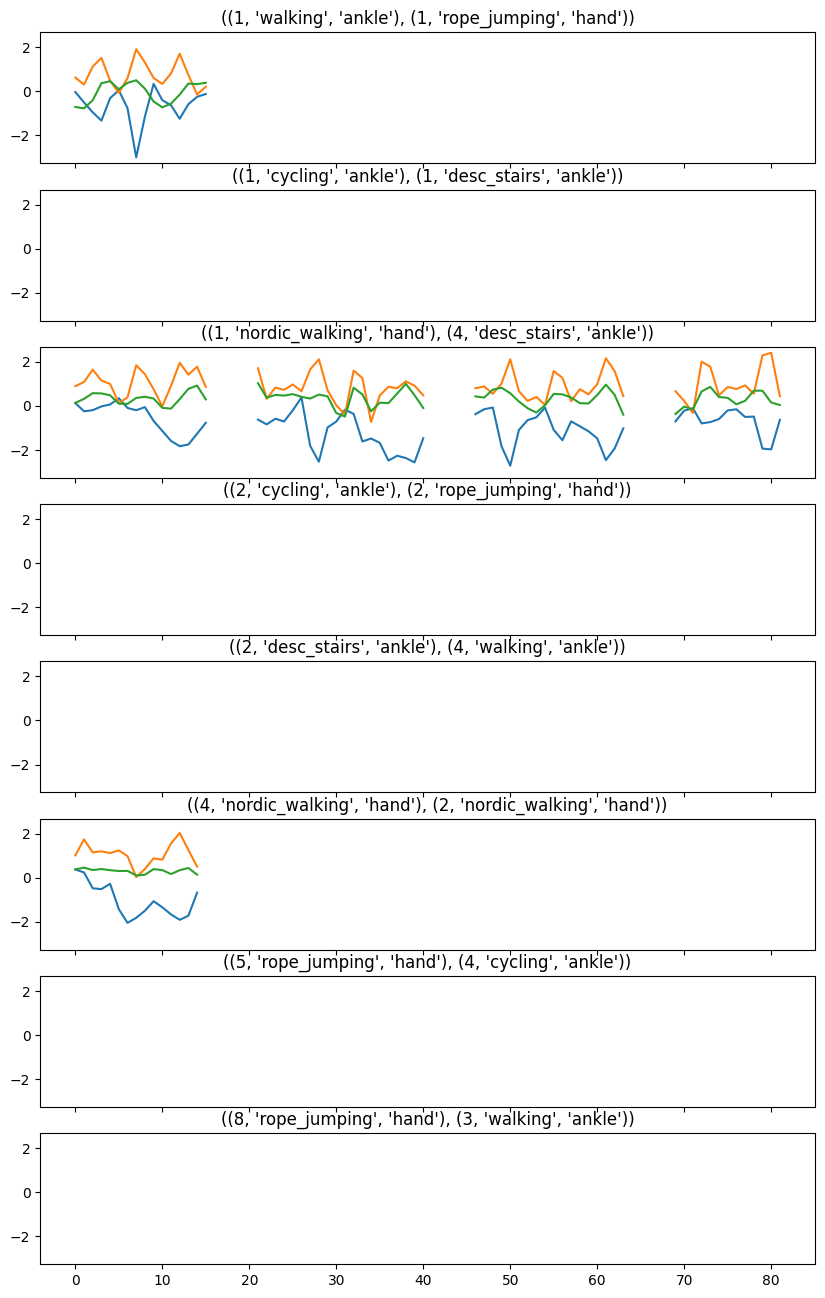

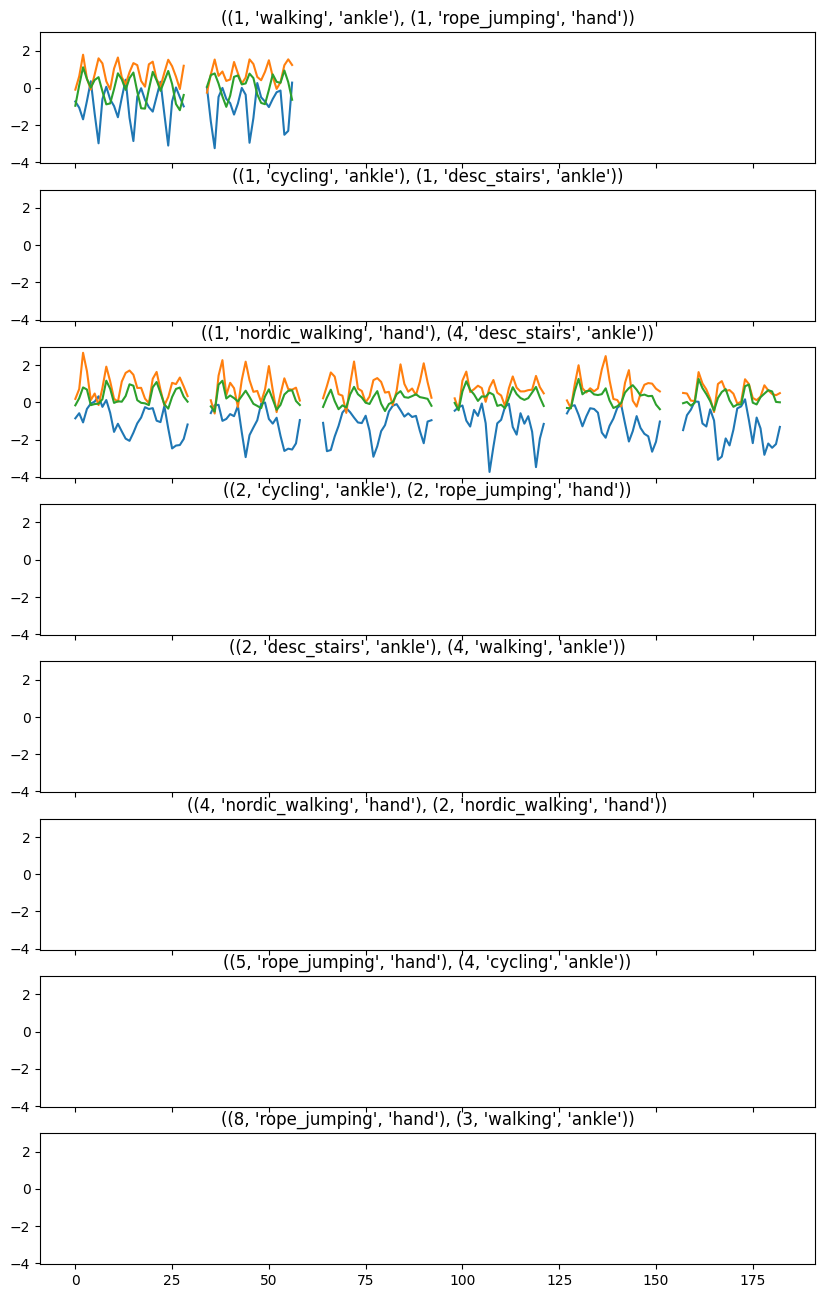

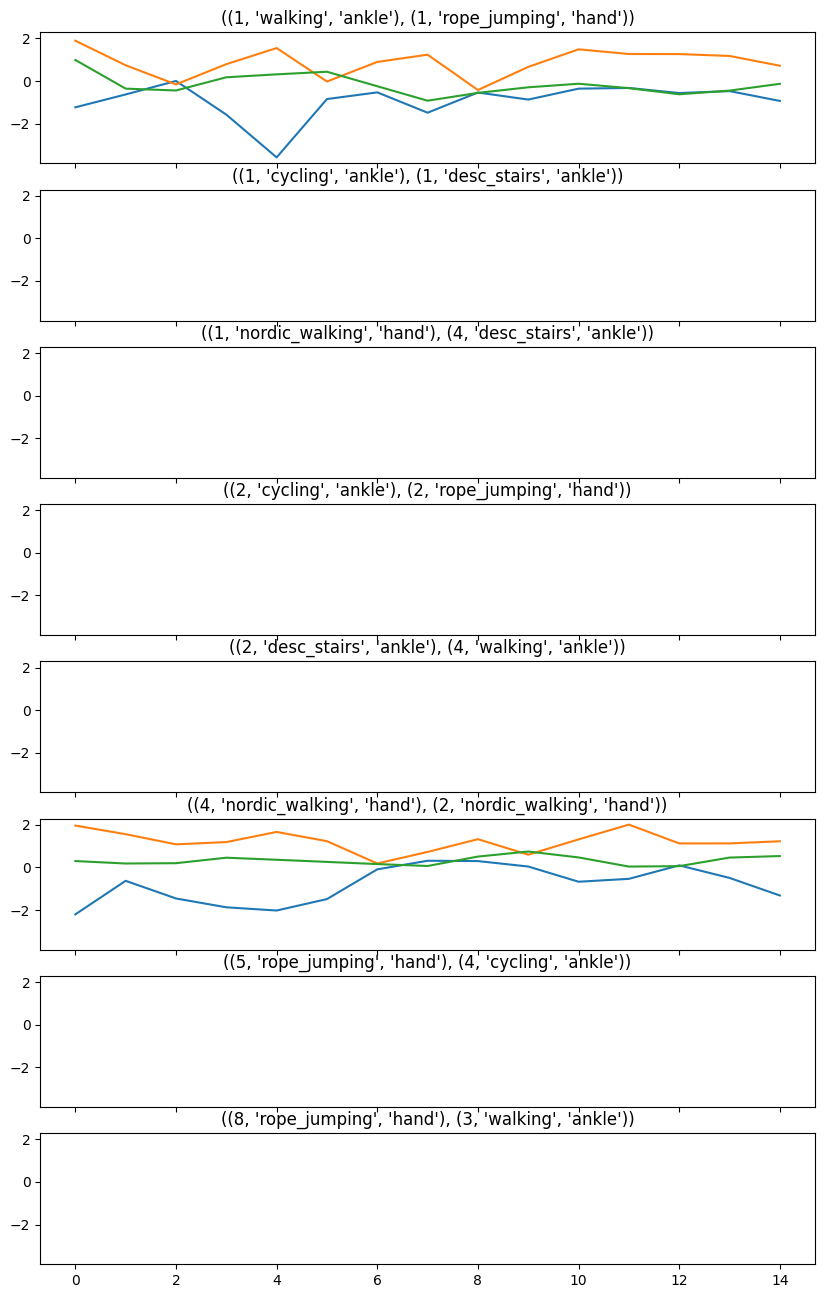

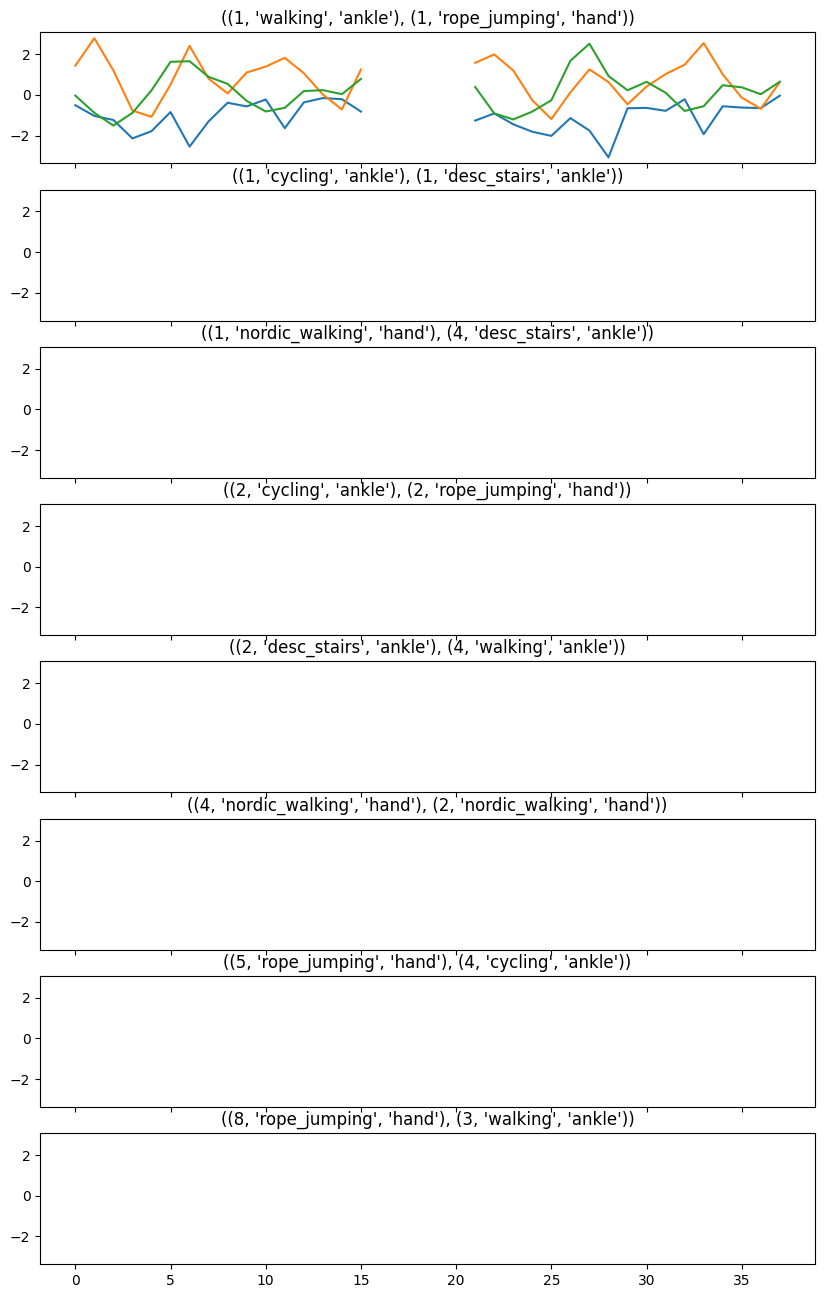

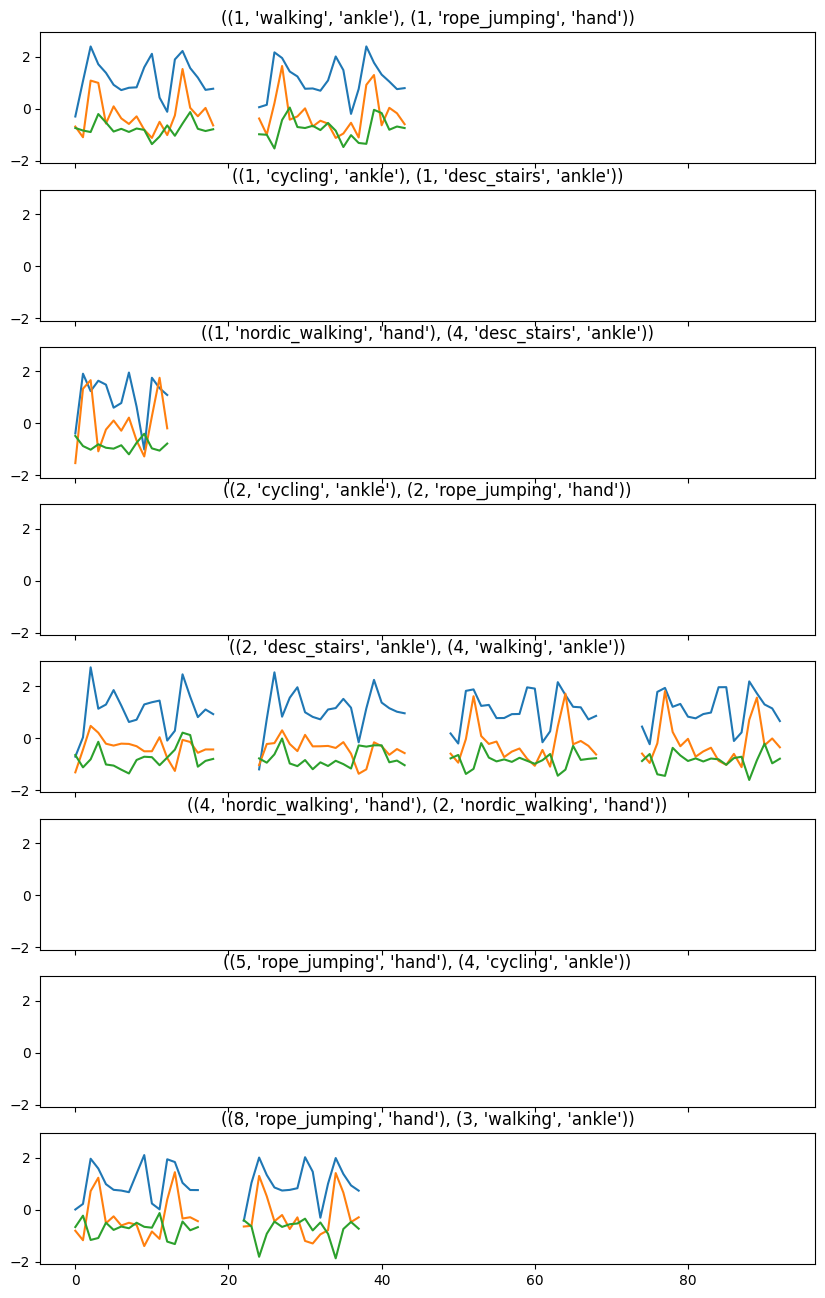

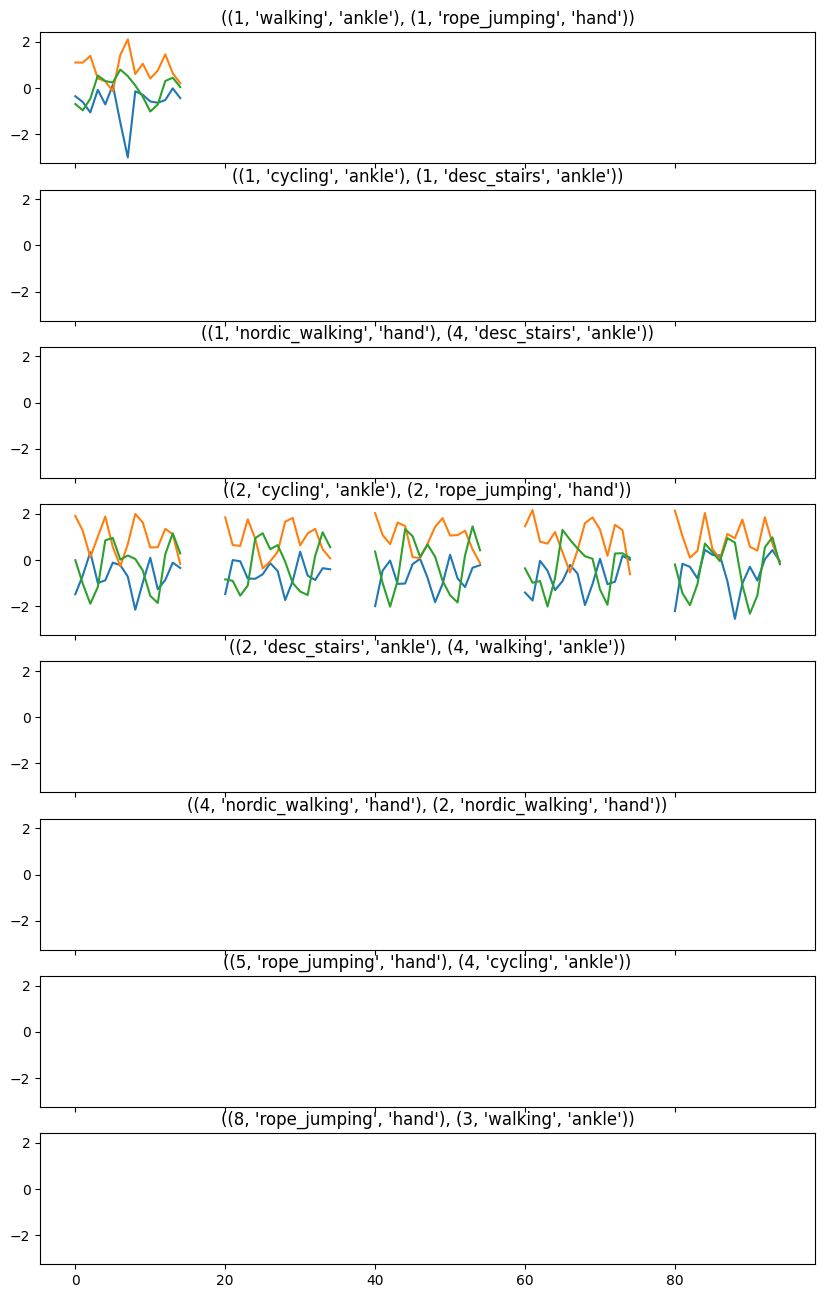

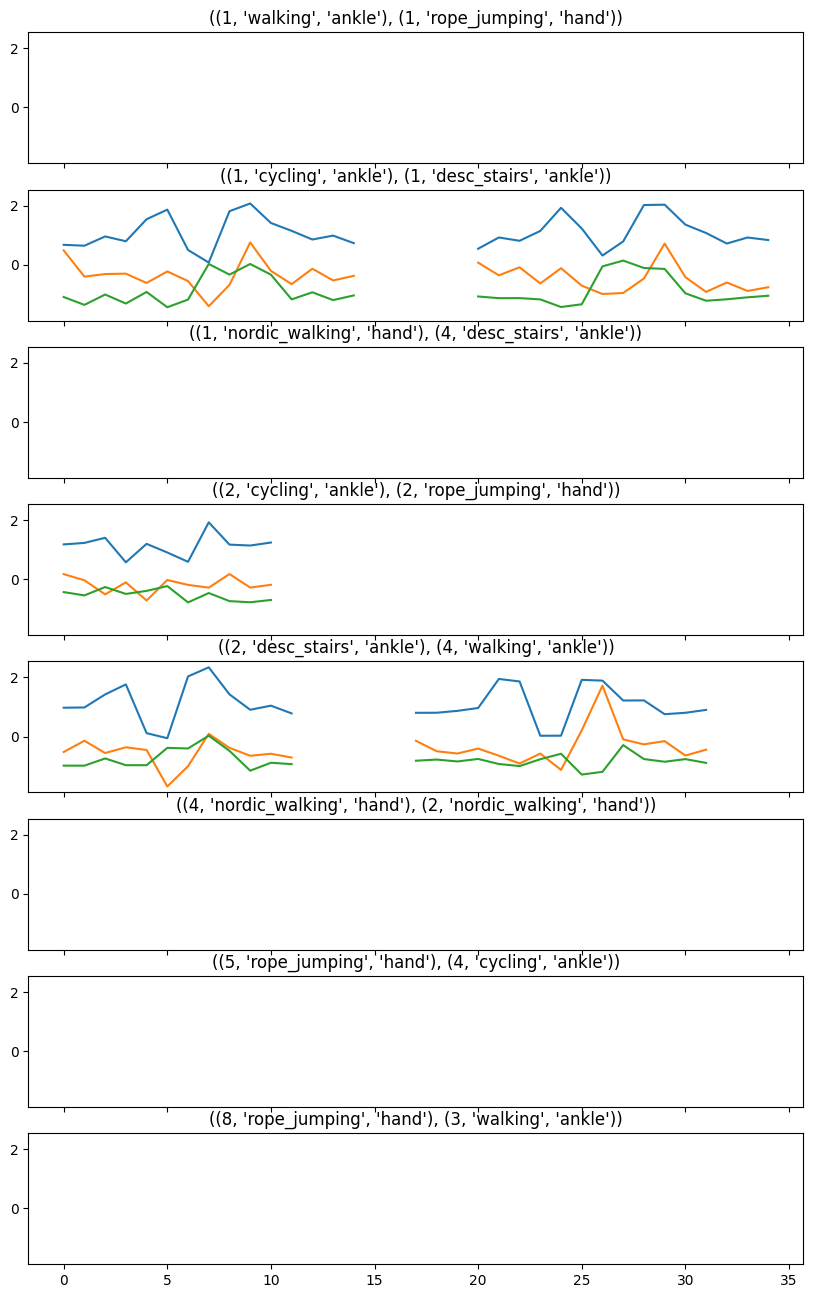

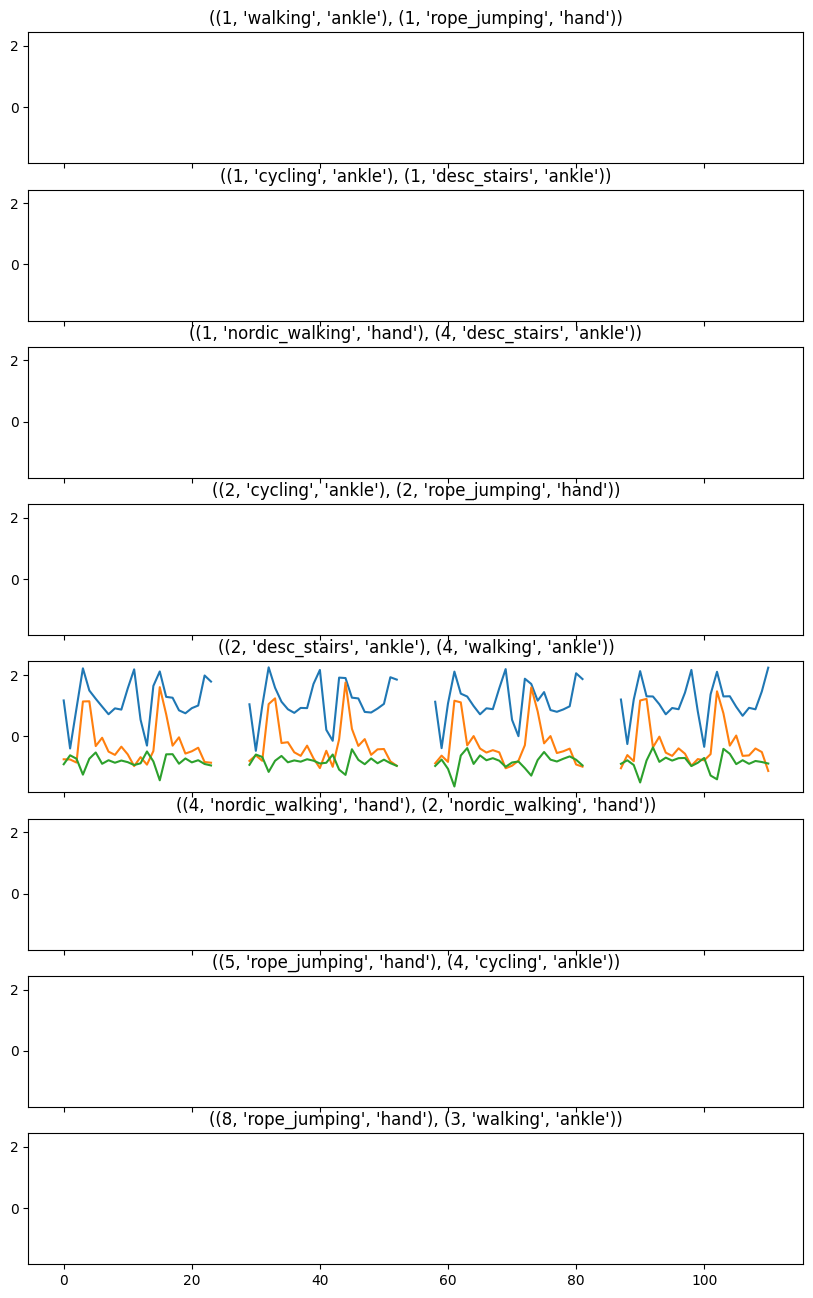

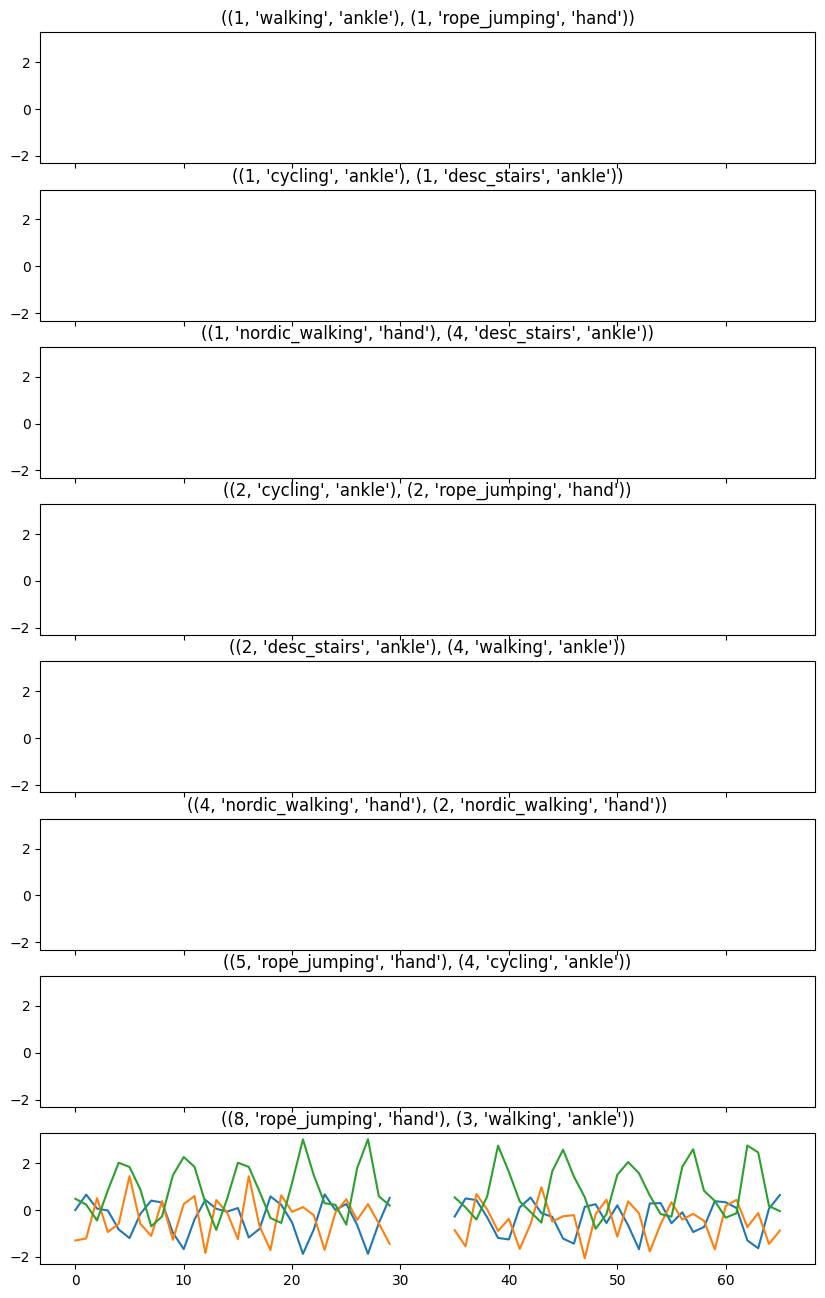

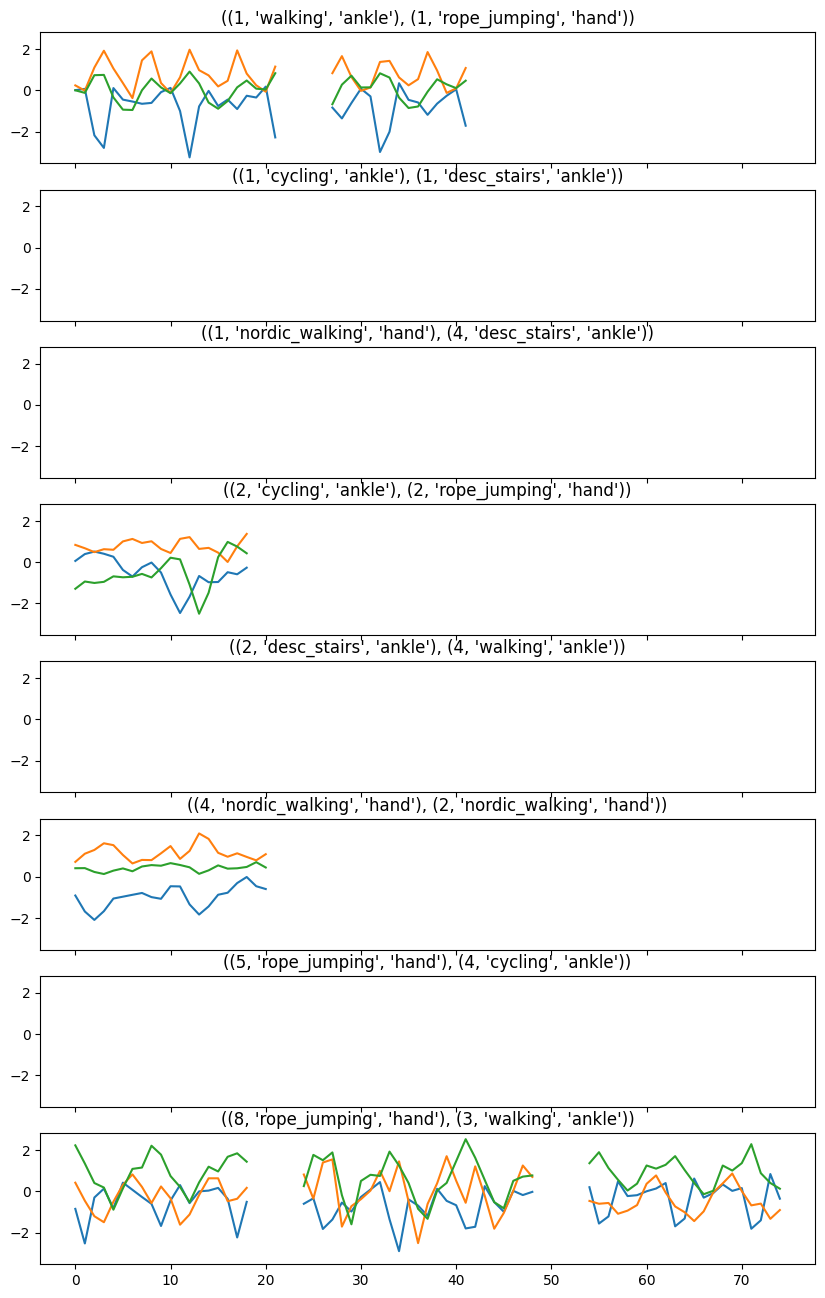

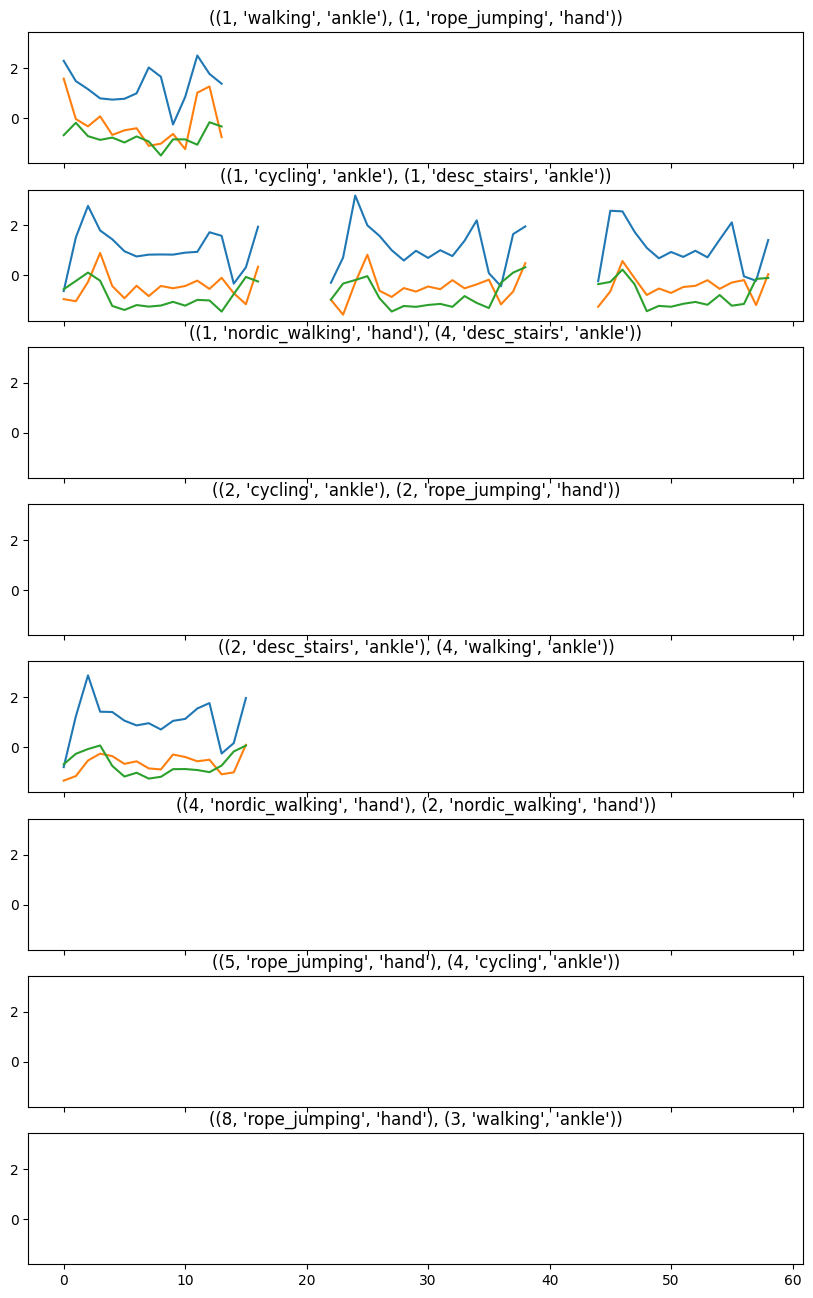

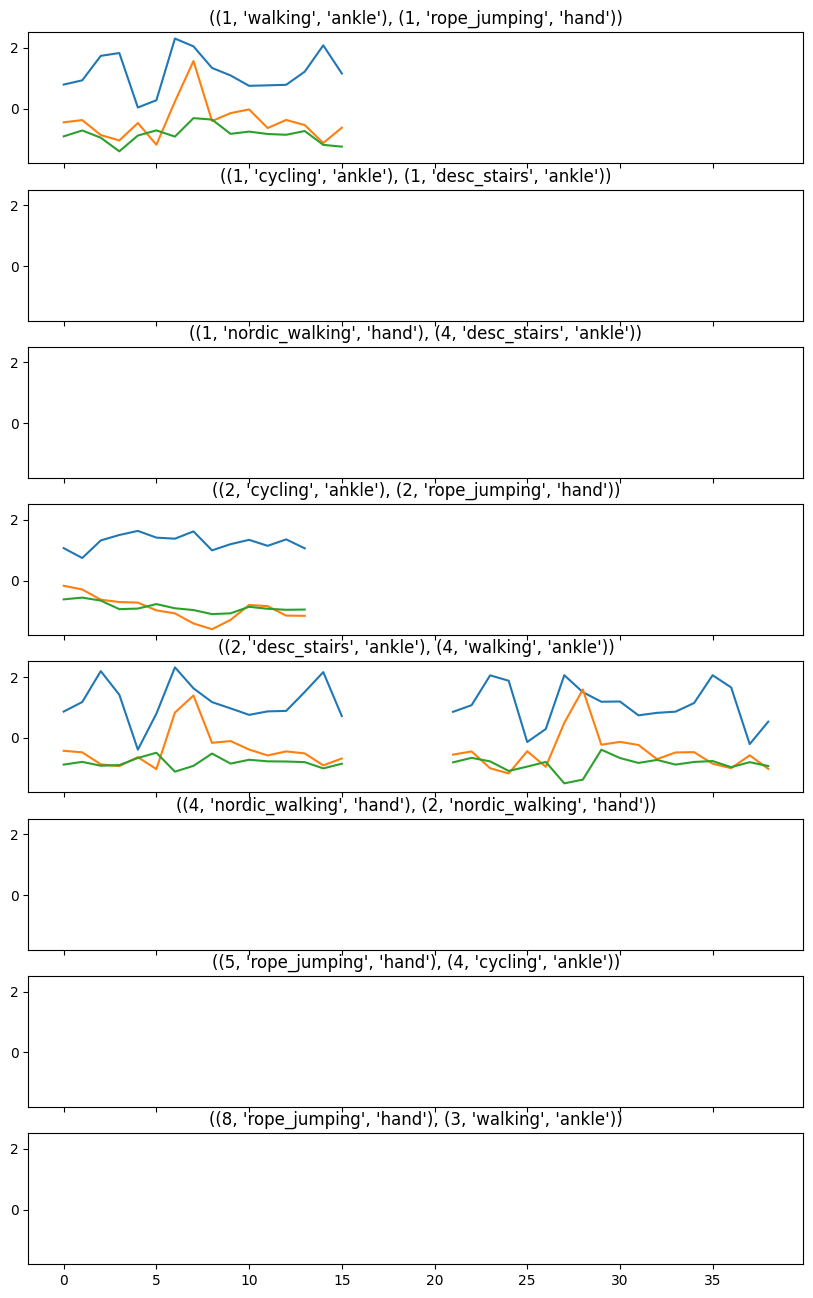

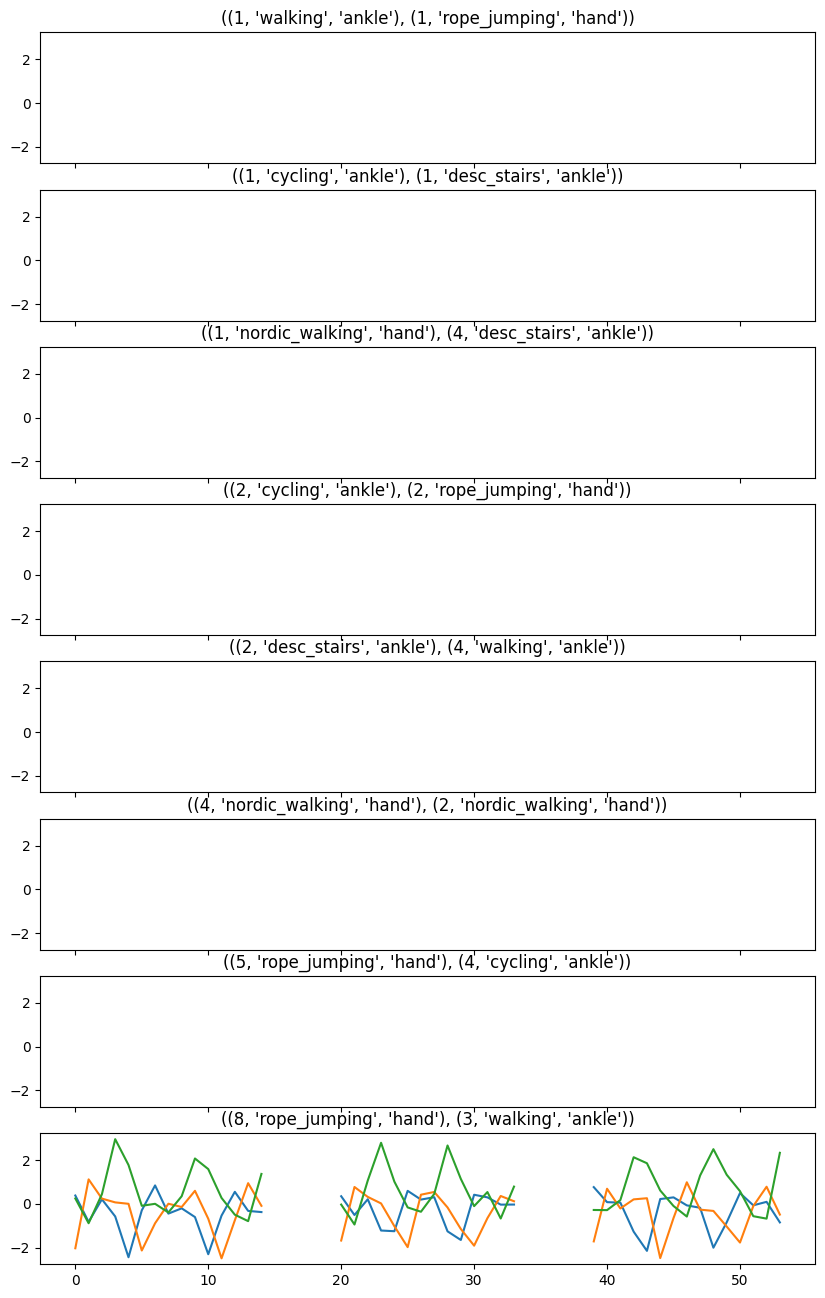

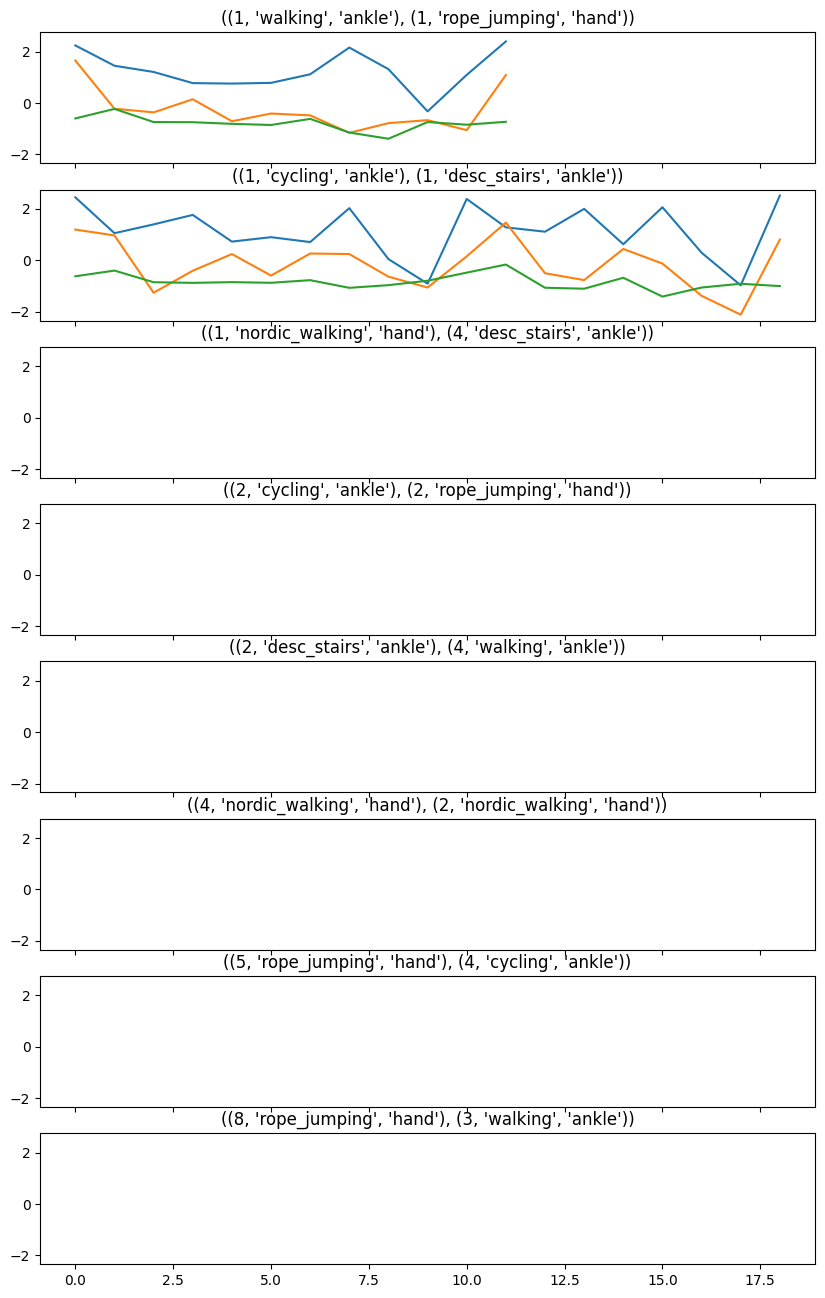

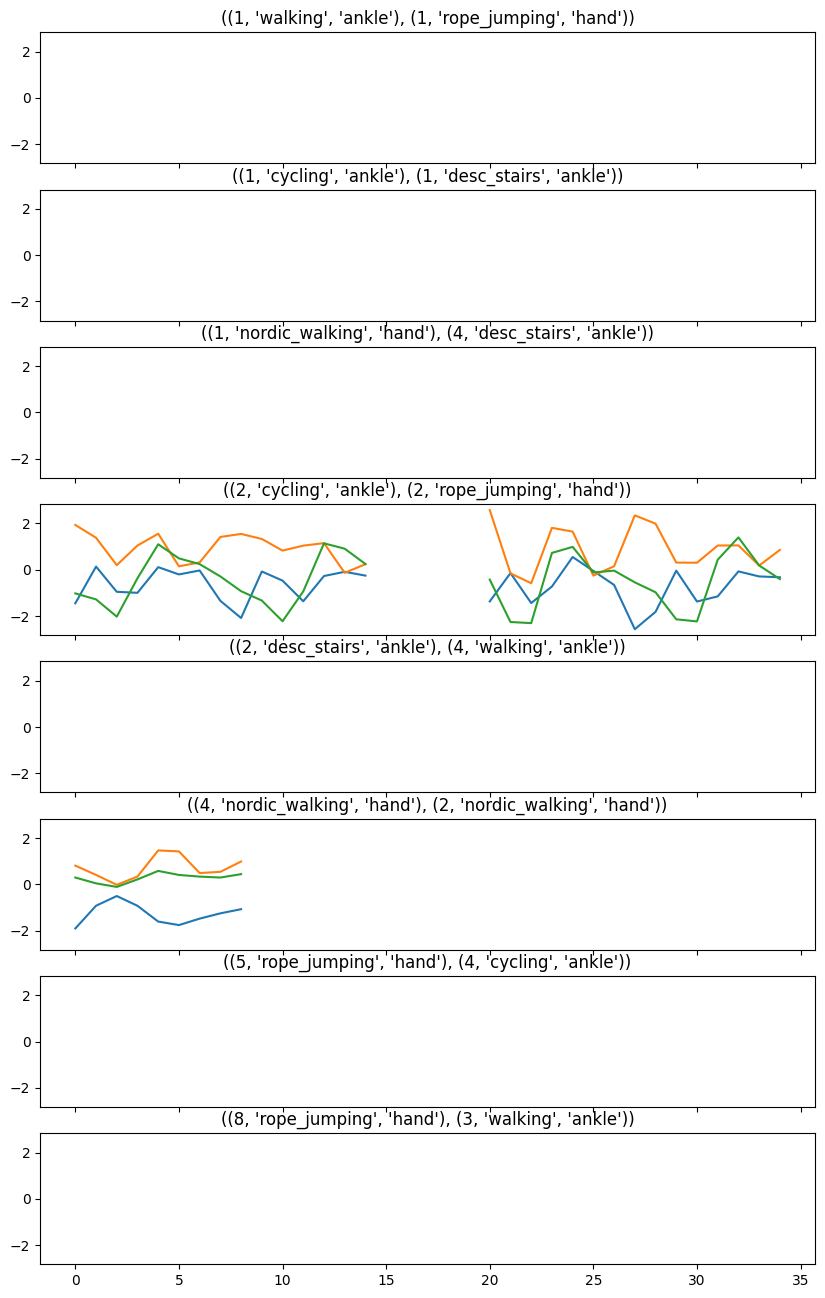

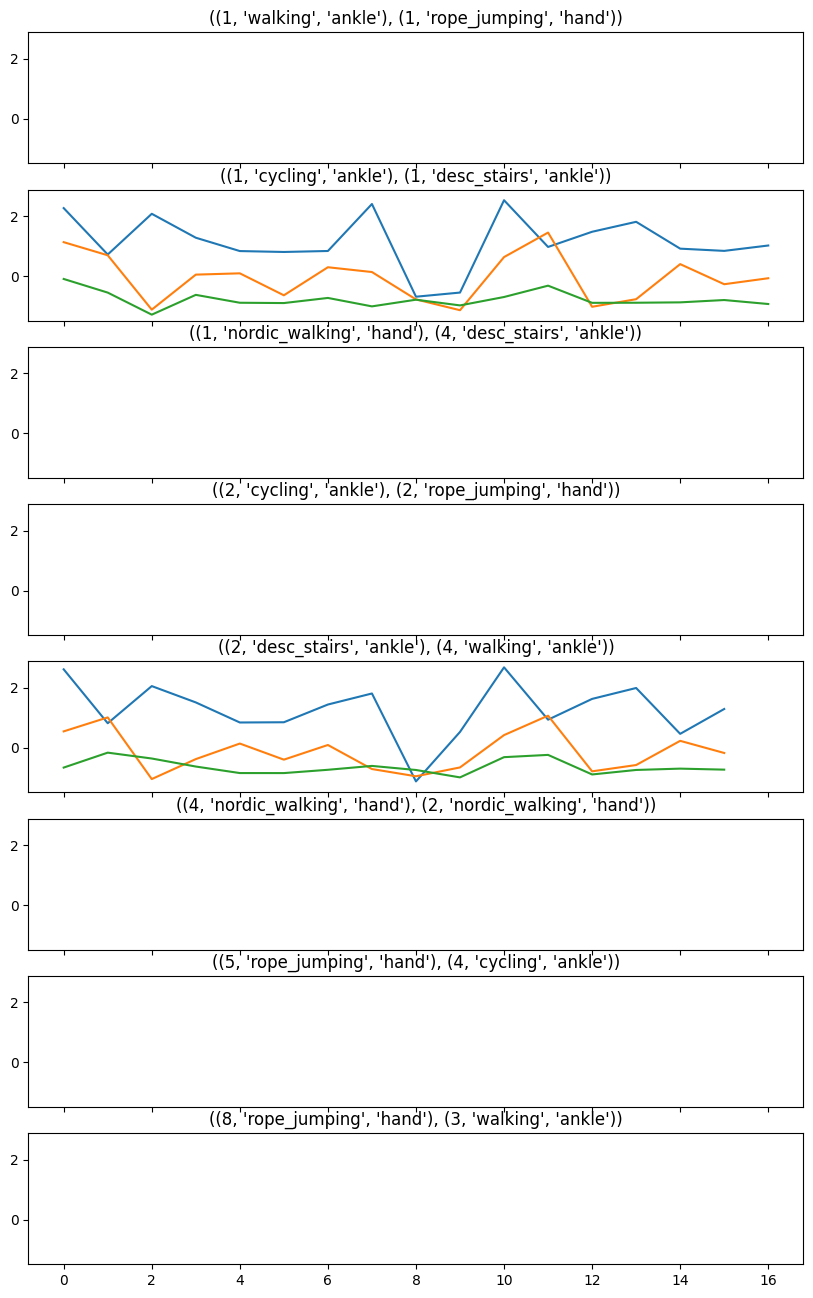

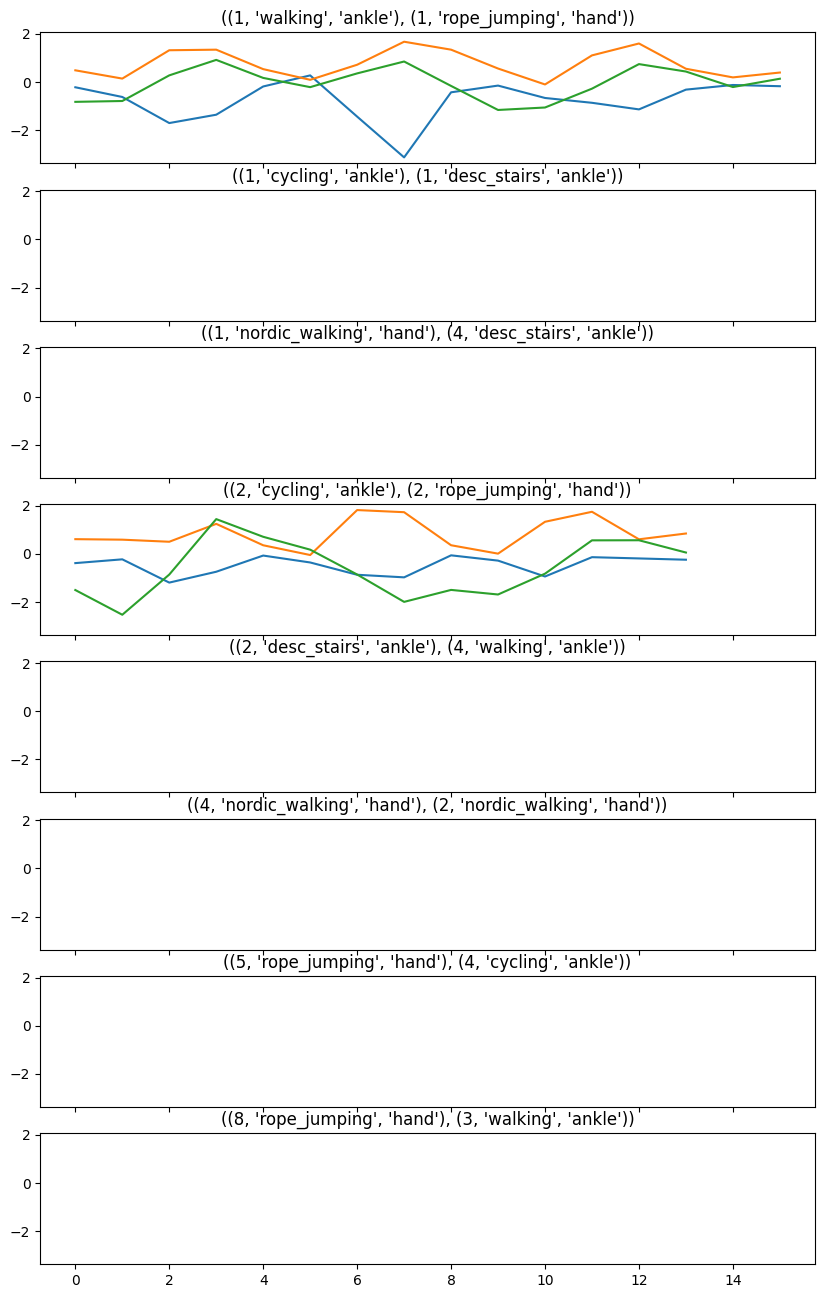

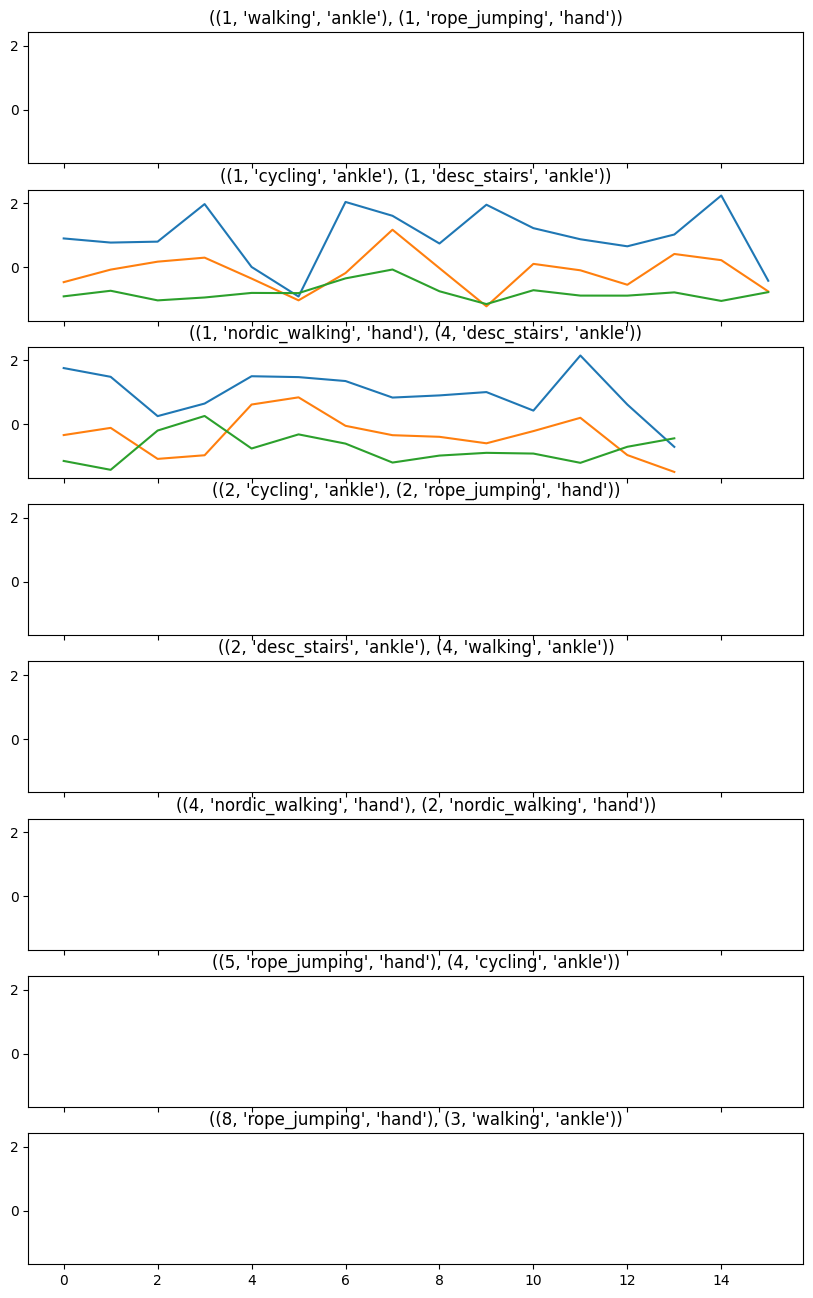

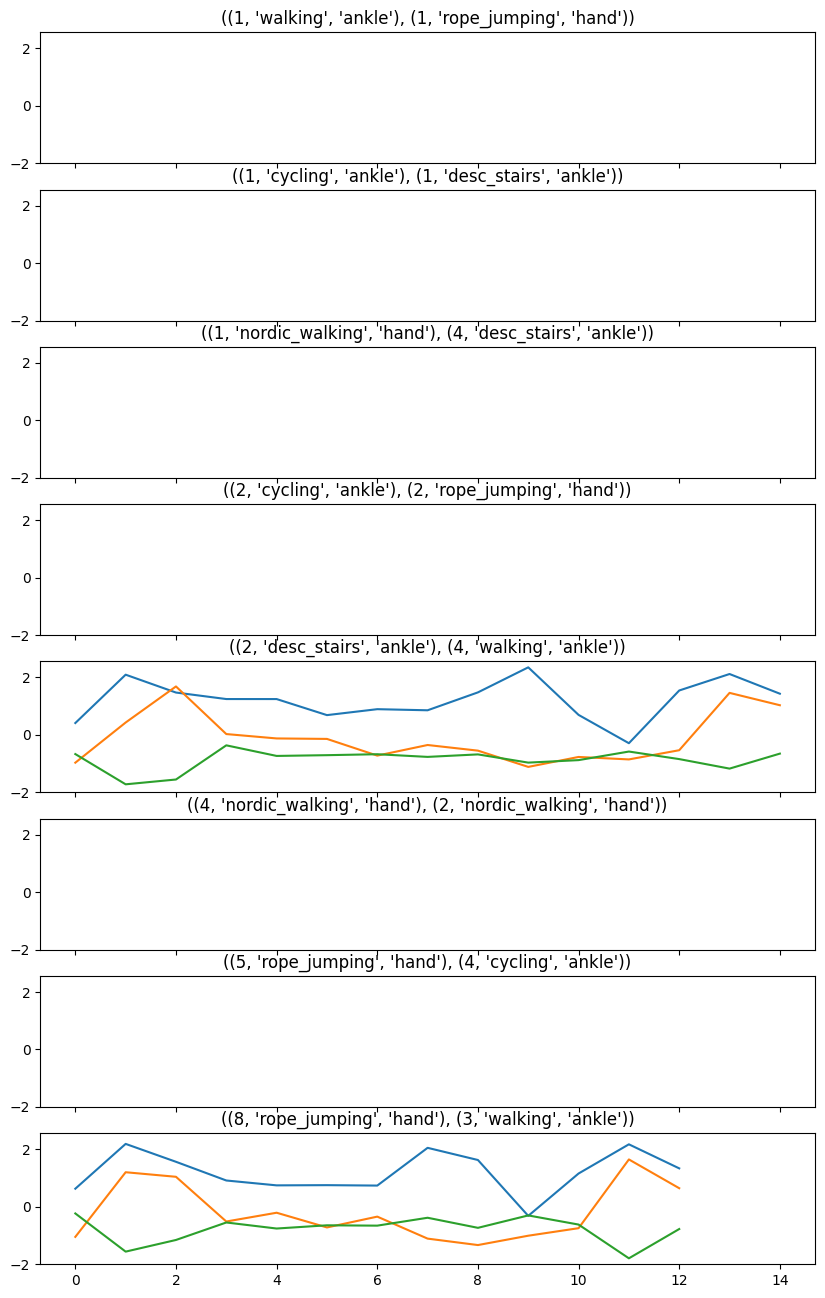

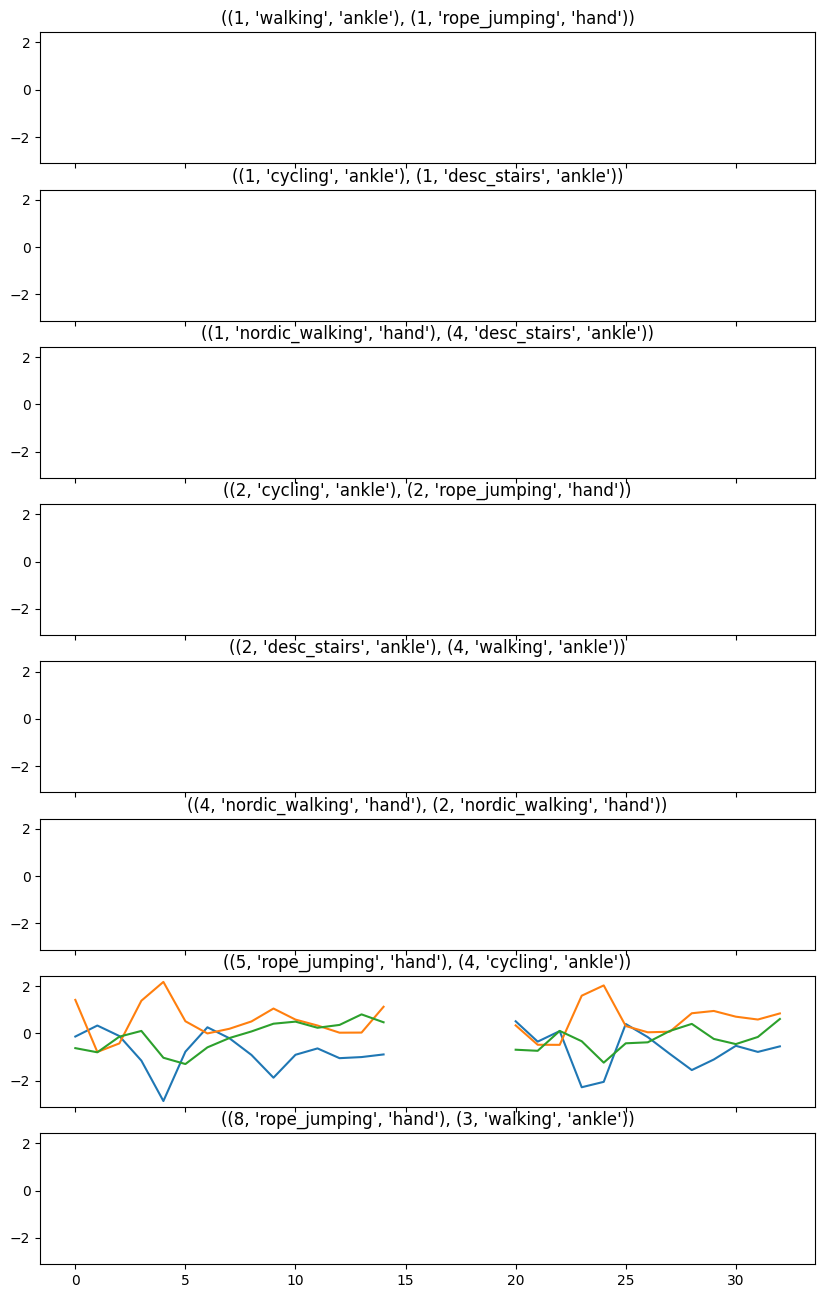

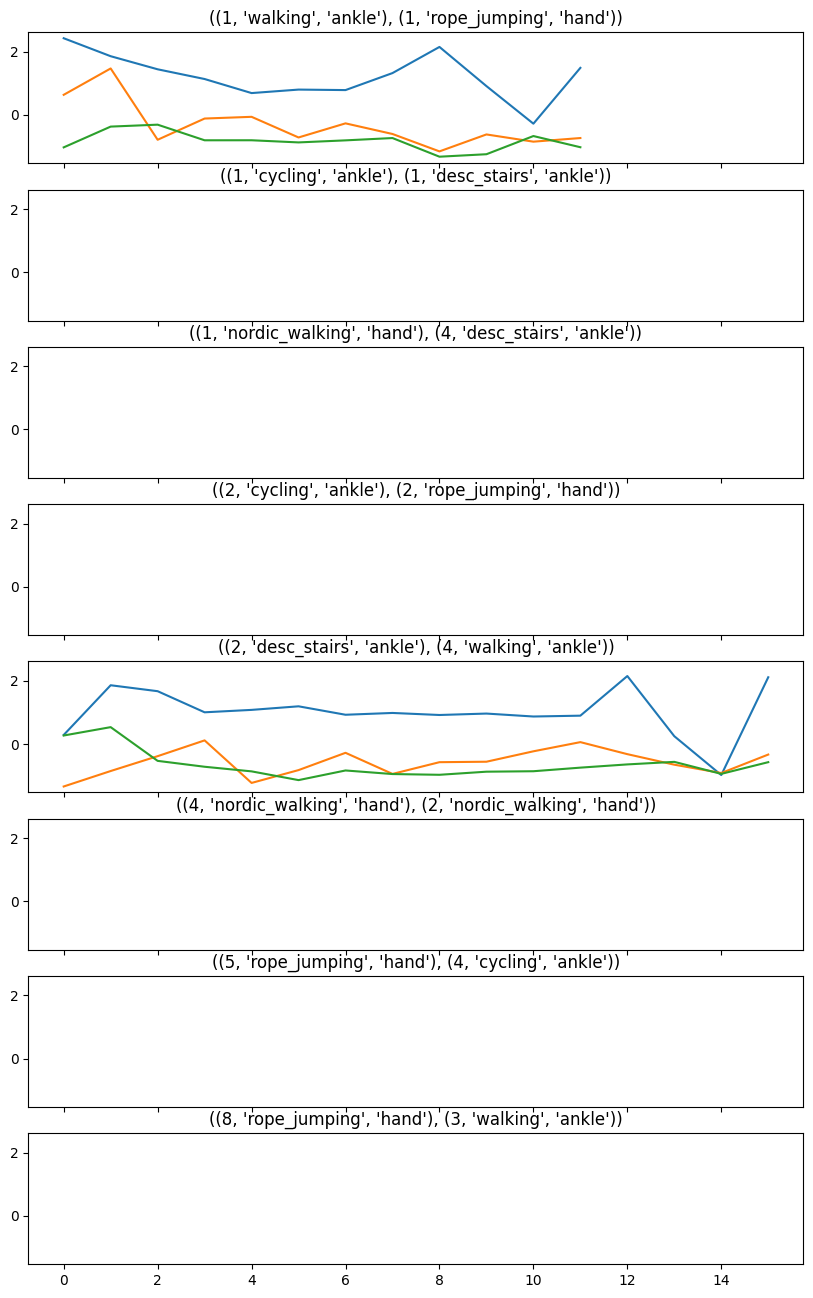

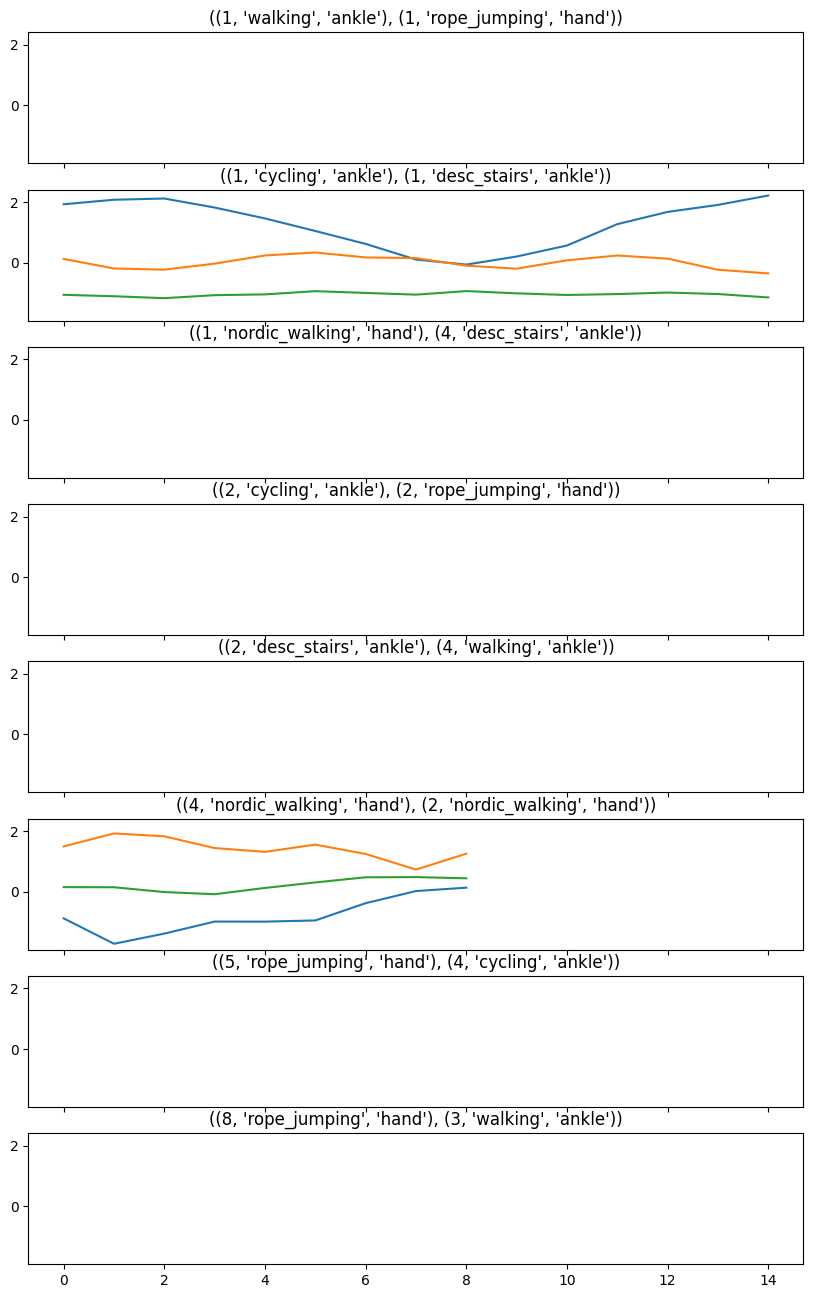

In [5]:
for i, cms in enumerate(Cms):
    for j, consensus_motifs in enumerate(cms):
        fig, ax = plt.subplots(n, 1, figsize=(10, 2 * len(Ts[i])), sharey=True, sharex=True)
        for k, motifs in consensus_motifs.items():
            curr = 0
            for ((b, e,), _) in motifs:
                ax[k].set_prop_cycle(None)
                l = e - b
                ax[k].plot(range(curr, curr+l), Ts[i][k][b:e])
                curr += l + 5
            ax[k].set_title(tuples[k])

        # plt.savefig(f'motifs_{j}.png')

In [25]:
S = np.zeros((n, n))

for cs in cms:
    for i in range(n):
        for j in range(n):
            cs1 = cs[i]
            cs2 = cs[j]
            mbf = 0
            for c in cs1:
                if c[1] > mbf:
                    mbf = c[1]
            for c in cs2:
                if c[1] > mbf:
                    mbf = c[1]
            S[i, j] += mbf * min(len(cs1), len(cs2))
    
smin = S.min()
smax = S.max()
S = (S - smin) / (smax - smin)

D = 1 - S
D[np.diag_indices(len(D))] = 0

print(D)


[[0.         0.96993808 0.9776641  0.99271187 0.99720252 0.99271187
  0.9676045  0.94600751 0.96313023 0.9234466  0.98472723 0.98472723]
 [0.96993808 0.         0.97263809 0.99271187 0.99720252 0.99271187
  0.9892015  0.9892015  0.9892015  0.98191337 1.         1.        ]
 [0.9776641  0.97263809 0.         0.95523597 0.98126205 0.95523597
  1.         1.         1.         0.98542374 1.         1.        ]
 [0.99271187 0.99271187 0.95523597 0.         0.92151321 0.8529241
  1.         1.         1.         0.99271187 0.94025116 0.94025116]
 [0.99720252 0.99720252 0.98126205 0.92151321 0.         0.74226669
  1.         1.         1.         1.         0.37263718 0.37263718]
 [0.99271187 0.99271187 0.95523597 0.8529241  0.74226669 0.
  1.         1.         1.         0.99271187 0.76100464 0.76100464]
 [0.9676045  0.9892015  1.         1.         1.         1.
  0.         0.85808373 0.97719891 0.94537265 0.99791297 0.99791297]
 [0.94600751 0.9892015  1.         1.         1.         1

In [26]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=5, affinity='precomputed', assign_labels='discretize')
clusters = spectral.fit_predict(S)

In [27]:
for c, l in zip(clusters, ts_names):
    print(f'{l} in {c}')

(2, 'walking') in 1
(3, 'walking') in 2
(4, 'walking') in 2
(1, 'cycling') in 3
(2, 'cycling') in 4
(4, 'cycling') in 3
(1, 'desc_stairs') in 0
(2, 'desc_stairs') in 0
(3, 'desc_stairs') in 1
(4, 'desc_stairs') in 1
((1, 'walking'), (1, 'rope_jumping')) in 4
((1, 'rope_jumping'), (1, 'walking')) in 4


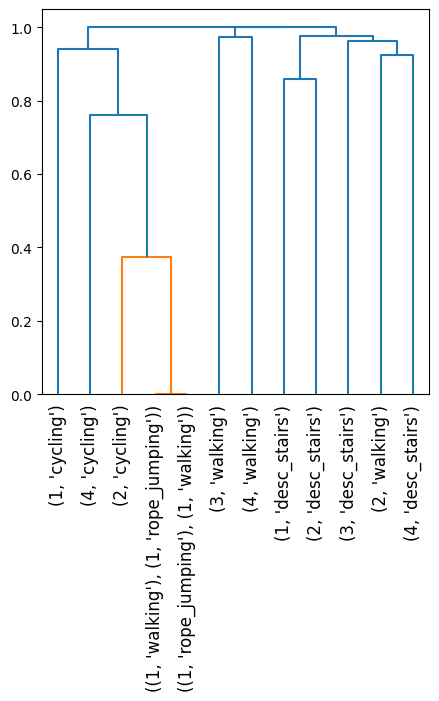

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform


Z = linkage(squareform(D), method='complete')
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=ts_names, ax=ax, leaf_rotation=90)
plt.show()